# Notebook 2 of 2 - Models and Evaluation

This notebook contains the following models:
1. Logistic regression
2. Adaboost
3. XGBoost
4. Deep neural networks (LTSM and standard deep neural network)

Each section contains the model architecture as well as experiments (e.g., ablation studies and grid search) used to tune hyperparameters

The notebook concludes with a section containing cross-model evaluations.

Note: due to filesize restrictions on github a csv called "data_augmented.csv" needs to be downloaded from google drive: https://drive.google.com/file/d/1YFsUk2InK1DFwCevVFNTWX3YY8JEWu2a/view?usp=sharing and should be saved under data/processed. This file is required to run the LTSM model

## Import Packages

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import random
import datetime
import re
import warnings

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from IPython.display import Image
from mlxtend.plotting import heatmap, plot_decision_regions
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV, KFold, RepeatedKFold

# XGBoost
import xgboost as xgb

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

# SciPy
import scipy.stats as stats
from scipy.stats import uniform, randint, f_oneway, ttest_ind
from scipy.optimize import curve_fit

# Set random seed
random.seed(1)

# Ignore warnings
warnings.filterwarnings('ignore')

2023-08-10 16:35:25.450086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### K-Fold set randomizer for all models
By setting a fixed seed value, we ensure that all models are evaluated on the same k-fold splits. 
This is essential for a fair comparison, as different random splits could lead to inconsistent comparisons between models.

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Load and preprocess data

In [3]:
df_features = pd.read_csv("../data/processed/selected_features_augmented.csv")
df_features.head()

,number,madrs2_grouped,madrs2_grouped_ord,Normal,Mild,Moderate,activity_entropy_hourly,activity_entropy_minutely,activity_intraday_variability,activity_kurtosis_daily,...,activity_std_hourly,bout_act_dur_kurtosis,bout_act_dur_std,bout_act_num,bout_inact_dur_cv,bout_inact_dur_entropy,bout_inact_dur_mean,bout_inact_dur_std,cos_day_of_week_amplitude,cos_minute_of_day_phase
0,condition_10a,Moderate,2,False,False,True,3.090006,8.410191,580.313080,4.922353,...,129786.695431,10.882228,29.732939,31.166667,2.608102,3.511655,41.814815,109.057303,23434.769636,-0.000614
1,condition_11a,Moderate,2,False,False,True,2.397121,7.848906,534.242943,11.504620,...,76671.259876,2.839172,9.721434,27.000000,2.644858,3.795606,42.429448,112.219855,101.062863,-0.000728
2,condition_12a,Moderate,2,False,False,True,2.968975,8.229882,413.815384,8.064285,...,54788.003541,15.361190,13.862598,33.833333,2.142199,4.402239,29.528634,63.256206,80852.744355,-0.000654
3,condition_13a,Mild,1,False,True,False,3.030332,8.365675,518.890851,6.814530,...,94796.845395,19.575901,16.398740,44.833333,2.336047,4.230671,24.599057,57.464554,-44.366424,-0.000682
4,condition_14a,Mild,1,False,True,False,2.223746,7.585908,398.457801,14.068851,...,30738.605961,19.880862,5.393473,22.500000,1.548695,4.458634,47.215470,73.122371,17.536681,0.000709


In [4]:
# Shuffle the data

# Extract indices
indices = np.arange(df_features.shape[0])

# Shuffle indices
np.random.seed(0)
shuffled_indices = np.random.permutation(indices)

# Reindex the shuffle indices
df_features = df_features.reindex(shuffled_indices)
display(df_features)

,number,madrs2_grouped,madrs2_grouped_ord,Normal,Mild,Moderate,activity_entropy_hourly,activity_entropy_minutely,activity_intraday_variability,activity_kurtosis_daily,...,activity_std_hourly,bout_act_dur_kurtosis,bout_act_dur_std,bout_act_num,bout_inact_dur_cv,bout_inact_dur_entropy,bout_inact_dur_mean,bout_inact_dur_std,cos_day_of_week_amplitude,cos_minute_of_day_phase
48,control_4a,Normal,0,True,False,False,2.762003,8.126940,700.989509,12.472631,...,141186.550295,18.992724,11.842712,37.333333,2.482901,4.467030,24.646388,61.194538,-47.503111,-0.000744
94,condition_1mod18,Moderate,2,False,False,True,2.963355,8.261457,536.686278,8.821234,...,102002.976073,6.925824,16.476781,37.666667,2.251315,4.174823,32.942708,74.164398,86244.608679,-0.000671
95,condition_1mod19,Moderate,2,False,False,True,2.773201,8.101063,541.195686,6.740036,...,77889.075365,154.933241,112.760633,27.333333,1.924115,4.400377,32.926702,63.354764,-23.105430,-0.000668
8,condition_18a,Mild,1,False,True,False,2.829157,8.038308,260.657740,11.680268,...,19346.033636,4.986149,5.128022,13.500000,2.335552,4.532586,46.876147,109.481679,244.921361,-0.000003
97,condition_1mod20,Moderate,2,False,False,True,2.848091,8.206915,499.667739,7.554527,...,77088.421333,8.953925,14.579427,34.166667,2.141759,4.297330,29.339901,62.839003,17529.388497,-0.000594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,condition_1mild20,Mild,1,False,True,False,3.013922,8.177700,641.123099,7.999890,...,120054.372014,40.610770,24.634082,35.166667,2.197452,4.325426,31.256281,68.684167,1745.922288,-0.000736
64,condition_1mild18,Mild,1,False,True,False,2.746588,8.117401,531.950387,6.542194,...,74466.646494,17.859823,18.113818,32.666667,1.962037,4.200593,36.594444,71.799667,51.881326,-0.000603
117,condition_1norm5,Normal,0,True,False,False,3.049873,8.359785,643.451252,6.034352,...,147372.707299,7.594854,18.787627,38.000000,2.073964,4.235107,29.038674,60.225167,-3334.248045,-0.000831
47,control_3a,Normal,0,True,False,False,2.974487,8.397519,482.653330,6.766699,...,92598.685731,13.385337,16.883622,40.333333,3.573289,3.447248,38.040936,135.931270,33260.340606,-0.000665


In [5]:
#drop unnecesarry column
df_depression = df_features.drop(['number',
                  'madrs2_grouped',
                  'Normal',
                  'Mild',
                  'Moderate'
                  ], axis=1)

label_names = ['Normal', 'Mild', 'Moderate']

df_depression.head(5)

,madrs2_grouped_ord,activity_entropy_hourly,activity_entropy_minutely,activity_intraday_variability,activity_kurtosis_daily,activity_kurtosis_hourly,activity_kurtosis_minutely,activity_mean,activity_mean_weekdays_0to6,activity_mean_weekdays_6to12,...,activity_std_hourly,bout_act_dur_kurtosis,bout_act_dur_std,bout_act_num,bout_inact_dur_cv,bout_inact_dur_entropy,bout_inact_dur_mean,bout_inact_dur_std,cos_day_of_week_amplitude,cos_minute_of_day_phase
48,0,2.762003,8.126940,700.989509,12.472631,10.929300,13.178305,216.934226,80.975238,183.766190,...,141186.550295,18.992724,11.842712,37.333333,2.482901,4.467030,24.646388,61.194538,-47.503111,-0.000744
94,2,2.963355,8.261457,536.686278,8.821234,10.430781,10.773371,229.221766,23.515337,203.995268,...,102002.976073,6.925824,16.476781,37.666667,2.251315,4.174823,32.942708,74.164398,86244.608679,-0.000671
95,2,2.773201,8.101063,541.195686,6.740036,10.282767,6.532382,186.343580,30.014684,131.400697,...,77889.075365,154.933241,112.760633,27.333333,1.924115,4.400377,32.926702,63.354764,-23.105430,-0.000668
8,1,2.829157,8.038308,260.657740,11.680268,10.757884,12.282823,73.666071,88.013810,66.046190,...,19346.033636,4.986149,5.128022,13.500000,2.335552,4.532586,46.876147,109.481679,244.921361,-0.000003
97,2,2.848091,8.206915,499.667739,7.554527,10.312997,6.400018,202.124276,21.026956,217.655176,...,77088.421333,8.953925,14.579427,34.166667,2.141759,4.297330,29.339901,62.839003,17529.388497,-0.000594


## Logistic regression

K-Fold cross validation will be implemented on the Logistic regression model. Regular k-fold cross validation will be better for our models because our dataset is small and the regular k-fold provides a good balance between training and validation data. This can help obtain more stable estimates of model performance.

### Run experiments for logistic regression using different hyperparameters (Ablation analysis) to find optimal hyperparameter configuration

In [6]:
def run_logregression_experiment(df_depression=df_depression,
                                  n_features=20,
                                  c=1.0,
                                  penalty='l2',
                                  solver='saga'):
    
    """
    Runs logistic regression with cross-validation. Returns a dataframe with average training accuracies, average validation accuracies, and average variance across folds

    Params:
        df_depression: dataframe with depression data
        df_results: dataframe to store results
        n_features: number of features to use
        c: inverse of regularization strength
        penalty: type of regularization
        solver: algorithm to use in optimization problem

    Returns:
        df_results: dataframe with results of experiment
    """
    
    # Print number of features used
    print(f"\nRunning experiment with {n_features} features, c={c}, penalty={penalty}, solver={solver}")
    print("-----------------------------------------------------------------------------------------")

    # Calculate column index for last feature
    last_feature_index = n_features + 1
    
    # Split the data into X and y
    X = np.array(df_depression.iloc[:, 1:last_feature_index])
    X_std = StandardScaler().fit_transform(X)
    y = np.array(df_depression.iloc[:, 0])

    # Define the evaluation procedure with k-fold cross-validation
    k_folds = 5
    cv = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

    # Create the logistic regression model with the best hyperparameters
    model = LogisticRegression(
        C=c,
        penalty=penalty,
        solver=solver,
        max_iter=2000,
    )

    # Lists to store training and validation scores for each fold
    train_accuracies = []
    validation_accuracies = []

    # Perform cross-validation and get training and validation scores for each fold
    for train_index, validation_index in cv.split(X_std, y):
        X_train, X_val = X_std[train_index], X_std[validation_index]
        y_train, y_val = y[train_index], y[validation_index]

        # Train the model on the training set within each fold
        model.fit(X_train, y_train)

        # Calculate training and validation accuracies
        train_accuracy = model.score(X_train, y_train)
        validation_accuracy = model.score(X_val, y_val)

        # Append the accuracies to the lists
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)

        # Print the accuracy for the current fold
        print(f"Fold {len(train_accuracies)} - Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    # Calculate average training and validation accuracies
    average_training_accuracy = np.mean(train_accuracies)
    average_validation_accuracy = np.mean(validation_accuracies)
    average_variance = average_training_accuracy - average_validation_accuracy # Include as a measure of overfitting

    # Print the overall statistics
    print("Average Training Accuracy:", average_training_accuracy)
    print("Average Validation Accuracy:", average_validation_accuracy)

    # Create a dataframe containing results of the experiment
    df_results = pd.DataFrame({
        'n_features': [n_features],
        'c': [c],
        'penalty': [penalty],
        'solver': [solver],
        'average_training_accuracy': [average_training_accuracy],
        'average_validation_accuracy': [average_validation_accuracy],
        'average_variance': [average_variance]
    })

    return df_results

In [7]:
# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['n_features', 'c', 'penalty', 'solver', 'average_training_accuracy', 'average_validation_accuracy', 'average_variance'])

### Test number of features to include

We hypothesized that including all features could lead to overfitting, whilst including too few features would impact performance. We sought to identify the optimal number of features that balances generalizability and accuracy

In [8]:
# Run the experiment and store results in df_results
for num_features in [5, 10, 15, 20, 25, 30]:
    df_results = pd.concat([df_results, run_logregression_experiment(n_features=num_features)], ignore_index=True)

df_results


Running experiment with 5 features, c=1.0, penalty=l2, solver=saga
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.6771, Validation Accuracy: 0.6250
Fold 2 - Training Accuracy: 0.7500, Validation Accuracy: 0.5833
Fold 3 - Training Accuracy: 0.6667, Validation Accuracy: 0.5833
Fold 4 - Training Accuracy: 0.6875, Validation Accuracy: 0.5833
Fold 5 - Training Accuracy: 0.6875, Validation Accuracy: 0.6250
Average Training Accuracy: 0.69375
Average Validation Accuracy: 0.6000000000000001

Running experiment with 10 features, c=1.0, penalty=l2, solver=saga
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.8333, Validation Accuracy: 0.7500
Fold 2 - Training Accuracy: 0.8438, Validation Accuracy: 0.6250
Fold 3 - Training Accuracy: 0.8646, Validation Accuracy: 0.8333
Fold 4 - Training Accuracy: 0.8125, Validation Accuracy: 0.7917
Fold 5 - Training Accura

,n_features,c,penalty,solver,average_training_accuracy,average_validation_accuracy,average_variance
0,5,1.0,l2,saga,0.693750,0.600000,0.093750
1,10,1.0,l2,saga,0.845833,0.758333,0.087500
2,15,1.0,l2,saga,0.895833,0.800000,0.095833
3,20,1.0,l2,saga,0.914583,0.816667,0.097917
4,25,1.0,l2,saga,0.933333,0.850000,0.083333
5,30,1.0,l2,saga,0.956250,0.816667,0.139583


From the above it appears that the best performance is achieved with using 25 features as the validation accuracy is higher and the variance (difference between training and validation accuracy is lowest)

### Test c hyperparameter

Hyperparameter 'C': represents the inverse of the regularization strength. It helps the balance between fitting the training data well and controlling model complexity through regularization. Especially helpful to prevent overfitting, which we have seen occur in our data. 

In [9]:
# Run the experiment for c hyperparameter and store results in df_results
for c in [0.01, 0.1, 1, 10]:
    df_results = pd.concat([df_results, run_logregression_experiment(n_features=25, c=c)], ignore_index=True)

df_results


Running experiment with 25 features, c=0.01, penalty=l2, solver=saga
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.8646, Validation Accuracy: 0.7917
Fold 2 - Training Accuracy: 0.8438, Validation Accuracy: 0.8750
Fold 3 - Training Accuracy: 0.8646, Validation Accuracy: 0.7917
Fold 4 - Training Accuracy: 0.8229, Validation Accuracy: 0.7917
Fold 5 - Training Accuracy: 0.8542, Validation Accuracy: 0.8333
Average Training Accuracy: 0.85
Average Validation Accuracy: 0.8166666666666667

Running experiment with 25 features, c=0.1, penalty=l2, solver=saga
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.8854, Validation Accuracy: 0.8750
Fold 2 - Training Accuracy: 0.8958, Validation Accuracy: 0.8750
Fold 3 - Training Accuracy: 0.9167, Validation Accuracy: 0.7917
Fold 4 - Training Accuracy: 0.8750, Validation Accuracy: 0.8333
Fold 5 - Training Accurac

,n_features,c,penalty,solver,average_training_accuracy,average_validation_accuracy,average_variance
0,5,1.00,l2,saga,0.693750,0.600000,0.093750
1,10,1.00,l2,saga,0.845833,0.758333,0.087500
2,15,1.00,l2,saga,0.895833,0.800000,0.095833
3,20,1.00,l2,saga,0.914583,0.816667,0.097917
4,25,1.00,l2,saga,0.933333,0.850000,0.083333
5,30,1.00,l2,saga,0.956250,0.816667,0.139583
6,25,0.01,l2,saga,0.850000,0.816667,0.033333
7,25,0.10,l2,saga,0.893750,0.858333,0.035417
8,25,1.00,l2,saga,0.933333,0.850000,0.083333
9,25,10.00,l2,saga,0.987500,0.833333,0.154167


From the above it appears that running with c = 0.10 and 25 features produces the best outcomes in terms of balancing validation accuracy and variance (difference between training and validation accuracies). A smaller value of 'C' results in a simpler model with a stronger regularization. 

### Test l1/l2 regularization hyperparameter

L1, L2 regularization: Used to prevent overfitting in the model. It adds a penalty term to the models loss function based on the extent of the models coefficients. The penalty term encourages the model to keep the coefficients small, this helps prevent the model from becoming too complex and overfitting the training data. 

In [10]:
# Run the experiment for penalty hyperparameter and store results in df_results
for penalty in ['l1', 'l2']:
    df_results = pd.concat([df_results, run_logregression_experiment(n_features=25, c=0.1, penalty=penalty)], ignore_index=True)

df_results


Running experiment with 25 features, c=0.1, penalty=l1, solver=saga
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.8438, Validation Accuracy: 0.8333
Fold 2 - Training Accuracy: 0.8438, Validation Accuracy: 0.7917
Fold 3 - Training Accuracy: 0.8229, Validation Accuracy: 0.7917
Fold 4 - Training Accuracy: 0.8438, Validation Accuracy: 0.7500
Fold 5 - Training Accuracy: 0.8750, Validation Accuracy: 0.8750
Average Training Accuracy: 0.8458333333333332
Average Validation Accuracy: 0.8083333333333332

Running experiment with 25 features, c=0.1, penalty=l2, solver=saga
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.8958, Validation Accuracy: 0.8750
Fold 2 - Training Accuracy: 0.8958, Validation Accuracy: 0.8750
Fold 3 - Training Accuracy: 0.9167, Validation Accuracy: 0.7917
Fold 4 - Training Accuracy: 0.8750, Validation Accuracy: 0.8333
Fold 5 - Tra

,n_features,c,penalty,solver,average_training_accuracy,average_validation_accuracy,average_variance
0,5,1.00,l2,saga,0.693750,0.600000,0.093750
1,10,1.00,l2,saga,0.845833,0.758333,0.087500
2,15,1.00,l2,saga,0.895833,0.800000,0.095833
3,20,1.00,l2,saga,0.914583,0.816667,0.097917
4,25,1.00,l2,saga,0.933333,0.850000,0.083333
5,30,1.00,l2,saga,0.956250,0.816667,0.139583
6,25,0.01,l2,saga,0.850000,0.816667,0.033333
7,25,0.10,l2,saga,0.893750,0.858333,0.035417
8,25,1.00,l2,saga,0.933333,0.850000,0.083333
9,25,10.00,l2,saga,0.987500,0.833333,0.154167


From the above it appears that l2 regularization outperforms l1 regularization. L2 regularization, encourages the model to distribute the impact of all features more evenly, without forcing any coefficients to be exactly zero. With L2, all features are likely important for making accurate predictions, but will need to control the impact of each feature to avoid overfitting. It balances the influence of all features, resulting in improved generalization to new data. 

### Test solver algorithms for Logistic Regression

'Solver': optimization algorithm is used to find the optimal coefficients (weights) of the model that minimize the loss function. Different solvers use different algorithms to perform the optimization:
- 'Newton-cg': Algorithm based on an iterative method for finding the maximum/ minimum of a function
- 'lbfgs': Limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm. This algorithm approximates the second derivative matrix updates with gradient evaluations. It's the default solver. both work well for small datasets.
- 'liblinear': uses coordinate descent, CD algorithm, works better for larger datasets.
- 'sag': Stochastic Average Gradient descent. This solver uses a variation of gradient descent and is often faster than other solvers for large datasets
- 'saga': Stochastic Average Gradient descent with Augmented Factorization and Intrinsic momentum. This is a variant of 'sag' that also supports the non-smooth penalty='l1' option (L1 Regularization). This is generally the best choice for large datasets.

In [11]:
# Run the experiment for solver hyperparameter and store results in df_results
for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    df_results = pd.concat([df_results, run_logregression_experiment(n_features=25, c=0.1, penalty='l2', solver=solver)], ignore_index=True)

df_results


Running experiment with 25 features, c=0.1, penalty=l2, solver=newton-cg
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.8958, Validation Accuracy: 0.8750
Fold 2 - Training Accuracy: 0.8958, Validation Accuracy: 0.8750
Fold 3 - Training Accuracy: 0.9167, Validation Accuracy: 0.7917
Fold 4 - Training Accuracy: 0.8750, Validation Accuracy: 0.8333
Fold 5 - Training Accuracy: 0.8958, Validation Accuracy: 0.9167
Average Training Accuracy: 0.8958333333333334
Average Validation Accuracy: 0.8583333333333334

Running experiment with 25 features, c=0.1, penalty=l2, solver=lbfgs
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.8958, Validation Accuracy: 0.8750
Fold 2 - Training Accuracy: 0.8958, Validation Accuracy: 0.8750
Fold 3 - Training Accuracy: 0.9167, Validation Accuracy: 0.7917
Fold 4 - Training Accuracy: 0.8750, Validation Accuracy: 0.8333
Fold 5

,n_features,c,penalty,solver,average_training_accuracy,average_validation_accuracy,average_variance
0,5,1.00,l2,saga,0.693750,0.600000,0.093750
1,10,1.00,l2,saga,0.845833,0.758333,0.087500
2,15,1.00,l2,saga,0.895833,0.800000,0.095833
3,20,1.00,l2,saga,0.914583,0.816667,0.097917
4,25,1.00,l2,saga,0.933333,0.850000,0.083333
5,30,1.00,l2,saga,0.956250,0.816667,0.139583
6,25,0.01,l2,saga,0.850000,0.816667,0.033333
7,25,0.10,l2,saga,0.893750,0.858333,0.035417
8,25,1.00,l2,saga,0.933333,0.850000,0.083333
9,25,10.00,l2,saga,0.987500,0.833333,0.154167


From the above it appears that liblinear is the least favorable solver algorithm in terms of validation accuracy and variance if we use n_features=25, c=0.1, penalty=l2. All other solver algorithms perform equally well (with marginal differences in variance), but we will select saga as it has the lowest variance.

Ablation analysis suggests the best hyperparameters are:
- n_features = 25
- c = 0.1
- penalty = l2
- solver = saga

Overall, it appears that the hyperparameter with the largest impact on model performance is n_features.

### Run grid search to confirm optimal hyperparameters

Here we will run a grid search using n_features = 25 to confirm whether the best model configuration is still the same as before.

In [13]:
def run_logregression_grid_search(df_depression=df_depression, n_features=25):
    """
    Conducts grid search using logistic regression with K-fold cross-validation for different n_features.

    Params:
        df_depression: dataframe with depression data
        n_features: number of features to use

    Returns:
        grid_search_results: a dictionary containing the best hyperparameters and corresponding accuracy
        cv_results_df: a pandas dataframe containing the cross-validation results
    """

    # Calculate column index for last feature
    last_feature_index = n_features + 1
    
    # Split the data into X and y
    X = np.array(df_depression.iloc[:, 1:last_feature_index])
    X_std = StandardScaler().fit_transform(X)
    y = np.array(df_depression.iloc[:, 0])

    # Define the logistic regression model
    model = LogisticRegression(max_iter=2000)

    best_params_list = []
    best_accuracy_list = []

    # Define the hyperparameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

    # define k-fold cross-validation experimentation
    k_folds = 5
    cv = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=cv, return_train_score=True)

    # Perform grid search on the data for the current number of features
    grid_search.fit(X_std, y)

    # Convert cv_results_ to a pandas DataFrame
    cv_results_df = pd.DataFrame(grid_search.cv_results_)

    # Remove rows from cv_results_ that have NaN mean_test_score
    cv_results_df = cv_results_df[cv_results_df['mean_test_score'].notna()]

    # Add a column for the number of features
    cv_results_df['n_features'] = n_features

    # Calculate mean variance (difference between test and train) for each hyperparameter combination
    cv_results_df['mean_variance'] = cv_results_df['mean_train_score'] - cv_results_df['mean_test_score']

    # Keep only the columns of interest
    cv_results_df = cv_results_df[['n_features', 'param_C', 'param_penalty', 'param_solver', 'mean_train_score', 'mean_test_score', 'mean_variance']]

    # Sort cv_results_ by mean_test_score and mean_variance(inverse) and reindex
    cv_results_df = cv_results_df.sort_values(by=['mean_test_score', 'mean_variance'], ascending=[False, True])
    cv_results_df = cv_results_df.reset_index(drop=True)

    # Name the index column as 'rank'
    cv_results_df.index.name = 'rank'

    # Add 1 to the index to make it easier to read
    cv_results_df.index = cv_results_df.index + 1

    return cv_results_df

# Call the function and store the results
df_logreg_gridsearch = run_logregression_grid_search()

# Output the results
print("Grid Search Results (Sorted by test_score):")
display(df_logreg_gridsearch)

# Print the best hyperparameters
print(f"Best Hyperparameters: {dict(df_logreg_gridsearch.iloc[0, 0:3])}")

Grid Search Results (Sorted by test_score):


,n_features,param_C,param_penalty,param_solver,mean_train_score,mean_test_score,mean_variance
rank,,,,,,,
1,25,0.1,l2,sag,0.893750,0.858333,0.035417
2,25,0.1,l2,saga,0.893750,0.858333,0.035417
3,25,0.1,l2,newton-cg,0.895833,0.858333,0.037500
4,25,0.1,l2,lbfgs,0.895833,0.858333,0.037500
5,25,1,l2,newton-cg,0.933333,0.850000,0.083333
6,25,1,l2,lbfgs,0.933333,0.850000,0.083333
7,25,1,l2,sag,0.933333,0.850000,0.083333
8,25,1,l2,saga,0.933333,0.850000,0.083333
9,25,0.1,l1,liblinear,0.854167,0.841667,0.012500


Best Hyperparameters: {'n_features': 25, 'param_C': 0.1, 'param_penalty': 'l2'}


Grid search using n_features=25 suggests n_features=25, c=0.1, penalty=l2, solver=sag/saga are the best hyperparameters. Aside from solver differences, this largely confirms the results of our ablation analysis as well. Ablation analysis suggested saga had slightly lower variance. So, we conclude that the best set of hyperparameters is:
- n_features = 25
- c = 0.1
- penalty = l2
- solver = saga

### Fit and evaluate model with optimal hyperparameter configuration

From doing the ablation study and comparing results to those of the grid search we found the model configuration with the best trade-off between high validation accuracy and low variance was:
n_features = 25, 'C' = 0.1, penalty: l2, solver = saga.

In [69]:
def run_logregression(df_depression, n_features, c, penalty, solver, metric):

    """
    Evaluates the logistic regression model with the optimal hyperparameters (based on grid search)

    Parameters:
        df_depression (pandas dataframe): The dataframe containing the depression dataset
        n_features (int): The number of features to use
        c (float): The inverse of regularization strength
        penalty (str): The type of regularization penalty to use
        solver (str): The solver to use for the optimization problem
        metric(str): The metric to output which are accuracy, f1_score, and recall
    Returns:
        df_accuracies (pandas dataframe): A dataframe containing the training and validation accuracies for each fold
    """

    # Calculate column index for last feature
    last_feature_index = n_features + 1

    # Split the data into X and y
    X = np.array(df_depression.iloc[:, 1:last_feature_index])
    X_std = StandardScaler().fit_transform(X)
    y = np.array(df_depression.iloc[:, 0])

    # Create the logistic regression model with the specified hyperparameters
    log_model = LogisticRegression(C=c, penalty=penalty, solver=solver, max_iter=2000)

    if metric == "accuracy":

        # Define the evaluation procedure with k-fold cross-validation
        k_folds = 5
        cv = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

        # Lists to store training and validation scores for each fold
        train_accuracies = []
        validation_accuracies = []

        # Perform cross-validation and get training and validation scores for each fold
        for train_index, validation_index in cv.split(X_std, y):
            X_train, X_val = X_std[train_index], X_std[validation_index]
            y_train, y_val = y[train_index], y[validation_index]

            # Train the model on the training set within each fold
            log_model.fit(X_train, y_train)

            # Calculate training and validation accuracies
            train_accuracy = log_model.score(X_train, y_train)
            validation_accuracy = log_model.score(X_val, y_val)

            # Append the accuracies to the lists
            train_accuracies.append(train_accuracy)
            validation_accuracies.append(validation_accuracy)

        # Store training and validation accuracies in a pandas dataframe
        df_accuracies = pd.DataFrame({
            'train_accuracy': train_accuracies,
            'validation_accuracy': validation_accuracies
        })

        # Name the index column as 'fold'
        df_accuracies.index.name = 'fold'

        # Start the index from 1 instead of 0
        df_accuracies.index += 1

        # Add a new row which is the average of all the folds
        df_accuracies.loc['Mean'] = df_accuracies.mean()

        return df_accuracies
    
    elif metric == "f1_score":

        # Define the evaluation procedure with k-fold cross-validation
        k_folds = 5
        cv = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

        # Lists to store training and validation scores for each fold
        train_f1_scores = [] 
        validation_f1_scores = []

        # Perform cross-validation and get training and validation scores for each fold
        for train_index, validation_index in cv.split(X_std, y):
            X_train, X_val = X_std[train_index], X_std[validation_index]
            y_train, y_val = y[train_index], y[validation_index]

            # Train the model on the training set within each fold
            log_model.fit(X_train, y_train)

            # Calculate training and validation F1 scores
            train_f1 = f1_score(y_train, log_model.predict(X_train), average='macro')
            validation_f1 = f1_score(y_val, log_model.predict(X_val), average='macro') 

            # Append the F1 scores to the lists
            train_f1_scores.append(train_f1)
            validation_f1_scores.append(validation_f1)

        # Store training and validation F1 scores in a pandas dataframe
        df_f1_scores = pd.DataFrame({
            'train_f1_score': train_f1_scores, # changed the column name from train_accuracy to train_f1_score
            'validation_f1_score': validation_f1_scores # changed the column name from validation_accuracy to validation_f1_score
        })

        # Name the index column as 'fold'
        df_f1_scores.index.name = 'fold'

        # Start the index from 1 instead of 0
        df_f1_scores.index += 1

        # Add a new row which is the average of all the folds
        df_f1_scores.loc['Mean'] = df_f1_scores.mean()

        return df_f1_scores
    
    elif metric == "recall":

        # Define the evaluation procedure with k-fold cross-validation
        k_folds = 5
        cv = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

        # Lists to store training and validation recall scores for each fold
        train_recalls = [] # changed the name from train_f1_scores to train_recalls
        validation_recalls = [] # changed the name from validation_f1_scores to validation_recalls

        # Perform cross-validation and get training and validation scores for each fold
        for train_index, validation_index in cv.split(X_std, y):
            X_train, X_val = X_std[train_index], X_std[validation_index]
            y_train, y_val = y[train_index], y[validation_index]

            # Train the model on the training set within each fold
            log_model.fit(X_train, y_train)

            # Calculate training and validation recall scores
            train_recall = recall_score(y_train, log_model.predict(X_train), average='macro') # replaced F1 score with recall_score
            validation_recall = recall_score(y_val, log_model.predict(X_val), average='macro') # replaced F1 score with recall_score

            # Append the recall scores to the lists
            train_recalls.append(train_recall)
            validation_recalls.append(validation_recall)

        # Store training and validation recall scores in a pandas dataframe
        df_recall_scores = pd.DataFrame({
            'train_recall_score': train_recalls, # changed the column name to train_recall_score
            'validation_recall_score': validation_recalls # changed the column name to validation_recall_score
        })

        # Name the index column as 'fold'
        df_recall_scores.index.name = 'fold'

        # Start the index from 1 instead of 0
        df_recall_scores.index += 1

        # Add a new row which is the average of all the folds
        df_recall_scores.loc['Mean'] = df_recall_scores.mean()

        return df_recall_scores

### Testing Logistic Regression Accuracy

,train_accuracy,validation_accuracy
fold,,
1,0.885417,0.875000
2,0.895833,0.875000
3,0.916667,0.791667
4,0.875000,0.833333
5,0.895833,0.916667
Mean,0.893750,0.858333


<Axes: title={'center': 'Logistic Regression: Training and Validation Accuracies'}, xlabel='Fold', ylabel='Accuracy'>

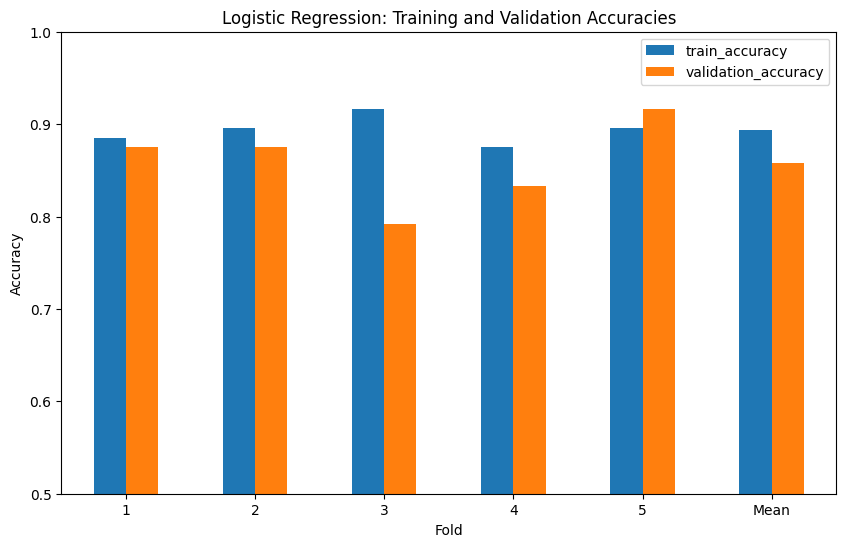

In [70]:
# Evaluate the logistic regression model with the optimal hyperparameters
df_final_logreg_accuracies = run_logregression(df_depression=df_depression, n_features=25, c=0.1, penalty='l2', solver='saga', metric='accuracy')

# Print the results
display(df_final_logreg_accuracies)

# Plot the training and validation accuracies
df_final_logreg_accuracies.plot(kind='bar', figsize=(10, 6), ylim=(0.5, 1.0), rot=0, title='Logistic Regression: Training and Validation Accuracies', xlabel='Fold', ylabel='Accuracy')

We can see that in general, validation accuracy is lower than training accuracy across folds, with the exception at fold 5.

### Testing Logistic Regression F1 Score

,train_f1_score,validation_f1_score
fold,,
1,0.895816,0.873677
2,0.897273,0.880028
3,0.916150,0.790476
4,0.874003,0.825146
5,0.894844,0.917714
Mean,0.895617,0.857408


<Axes: title={'center': 'Logistic Regression: Training and Validation F1 Scores'}, xlabel='Fold', ylabel='F1 Score'>

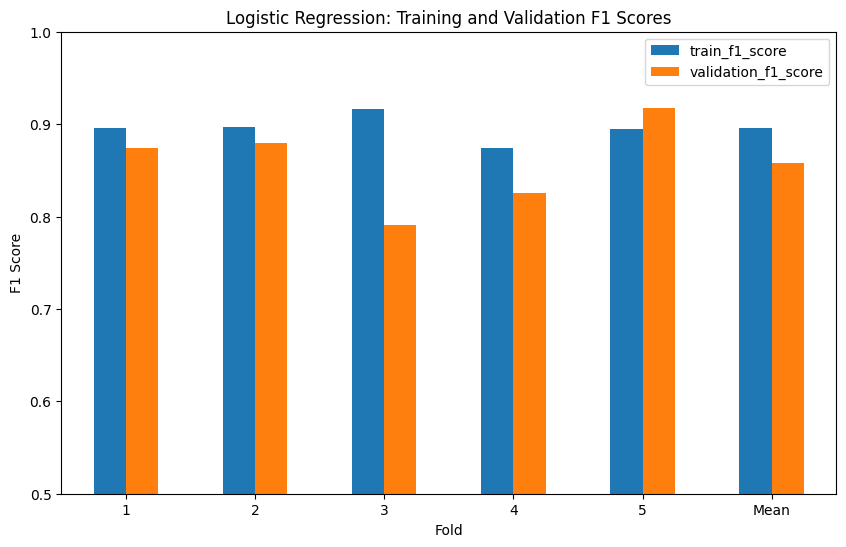

In [72]:
# Evaluate the logistic regression model with the optimal hyperparameters
df_final_logreg_f1_scores = run_logregression(df_depression=df_depression, n_features=25, c=0.1, penalty='l2', solver='saga', metric='f1_score')

# Print the results
display(df_final_logreg_f1_scores)

# Plot the training and validation accuracies
df_final_logreg_f1_scores.plot(kind='bar', figsize=(10, 6), ylim=(0.5, 1.0), rot=0, title='Logistic Regression: Training and Validation F1 Scores', xlabel='Fold', ylabel='F1 Score')

We observe a similar pattern with F1 score.

### Testing Logistic Regression Recall

,train_recall_score,validation_recall_score
fold,,
1,0.896814,0.850000
2,0.885919,0.785185
3,0.906061,0.790476
4,0.870926,0.886040
5,0.873814,0.888889
Mean,0.886707,0.840118


<Axes: title={'center': 'Logistic Regression: Training and Validation Recall Scores'}, xlabel='Fold', ylabel='Recall'>

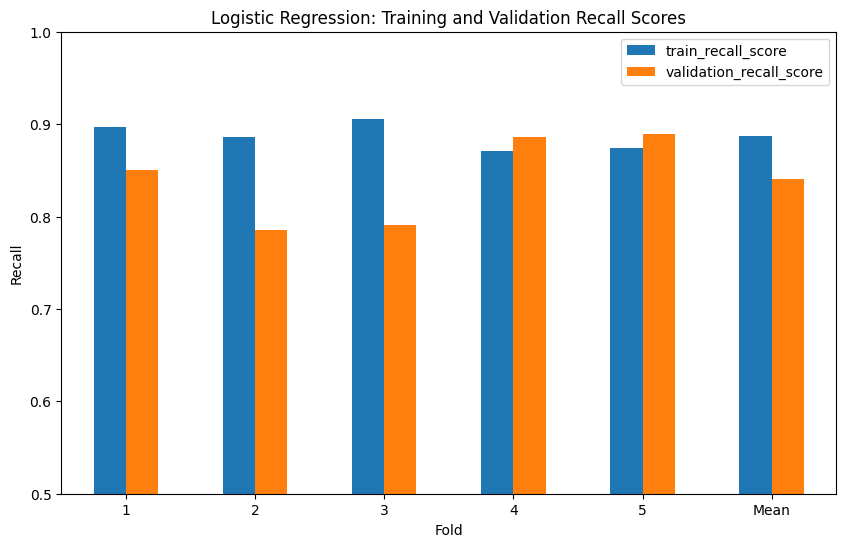

In [73]:
# Evaluate the logistic regression model with the optimal hyperparameters
df_final_logreg_recall_scores = run_logregression(df_depression=df_depression, n_features=20, c=0.1, penalty='l2', solver='saga', metric='recall')

# Print the results
display(df_final_logreg_recall_scores)

# Plot the training and validation accuracies
df_final_logreg_recall_scores.plot(kind='bar', figsize=(10, 6), ylim=(0.5, 1.0), rot=0, title='Logistic Regression: Training and Validation Recall Scores', xlabel='Fold', ylabel='Recall')

With recall, we observe more instances of validation score exceeding training score.

## Adaboost

The initial formulation of the boosting algorithm (4 key steps):<br>
 1. Draw a random sample of training examples, 𝑑𝑑1, without
replacement from the training dataset, D, to train a weak learner, 𝐶𝐶1.
 2. Draw a second random sample of training examples, 𝑑𝑑2, without replacement from the
training dataset and add 50 percent of the examples that were previously
misclassified to train a weak learner, 𝐶𝐶2.
 3. Find the training examples, 𝑑𝑑3, in the training dataset, D, which 𝐶𝐶1 and 𝐶𝐶2
disagree upon, to train a third weak learner, 𝐶𝐶3.
 4. Combine the weak learners 𝐶𝐶1, 𝐶𝐶2, and 𝐶𝐶3 via majority voting.

In [19]:
def run_ada_experiment(df_depression=df_depression,
                                  n_features=20,
                                  max_depth=1,
                                  n_estimators=800,
                                  learning_rate=1.2
                                  ):
    
    """
    Runs AdaBoost with cross-validation. Returns a dataframe with average training accuracies, average validation accuracies, and average variance across folds

    Params:
        df_depression: dataframe with depression data
        n_features: number of features
        max_depth: weak learner tree depth
        n_estimators: number of trees
        learning_rate: learning rate

    Returns:
        df_results: dataframe with results of experiment
    """
    
    # Print number of features used
    print(f"\nRunning experiment with {n_features} features, n estimators={n_estimators}, learning rate={learning_rate}")
    print("-----------------------------------------------------------------------------------------")

    # Calculate column index for last feature
    last_feature_index = n_features + 1
    
    # Split the data into X and y
    X = np.array(df_depression.iloc[:, 1:last_feature_index])
    X_std = StandardScaler().fit_transform(X)
    y = np.array(df_depression.iloc[:, 0])

    # Define the evaluation procedure with k-fold cross-validation
    k_folds = 5
    cv = KFold(n_splits=k_folds, shuffle=True, random_state=1)

    # Create the logistic regression model with the best hyperparameters
    base = DecisionTreeClassifier(max_depth=max_depth,criterion='entropy')
    model = AdaBoostClassifier(
        base_estimator=base,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
    )

    # Lists to store training and validation scores for each fold
    train_accuracies = []
    validation_accuracies = []

    # Perform cross-validation and get training and validation scores for each fold
    for train_index, validation_index in cv.split(X_std, y):
        X_train, X_val = X_std[train_index], X_std[validation_index]
        y_train, y_val = y[train_index], y[validation_index]

        # Train the model on the training set within each fold
        model.fit(X_train, y_train)

        # Calculate training and validation accuracies
        train_accuracy = model.score(X_train, y_train)
        validation_accuracy = model.score(X_val, y_val)

        # Append the accuracies to the lists
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)

        # Print the accuracy for the current fold
        print(f"Fold {len(train_accuracies)} - Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    # Calculate average training and validation accuracies
    average_training_accuracy = np.mean(train_accuracies)
    average_validation_accuracy = np.mean(validation_accuracies)
    average_variance = average_training_accuracy - average_validation_accuracy # Include as a measure of overfitting

    # Print the overall statistics
    print("Average Training Accuracy:", average_training_accuracy)
    print("Average Validation Accuracy:", average_validation_accuracy)

    # Create a dataframe containing results of the experiment
    df_results = pd.DataFrame({
        'n_features': [n_features],
        'n_estimators': [n_estimators],
        'learning rate': [learning_rate],
        'average_training_accuracy': [average_training_accuracy],
        'average_validation_accuracy': [average_validation_accuracy],
        'average_variance': [average_variance]
    })

    return df_results

In [20]:
# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['n_features', 'n_estimators', 'learning rate', 'average_training_accuracy', 'average_validation_accuracy', 'average_variance'])

### Test number of features to include

In [21]:
# Run the experiment and store results in df_results
for num_features in [5, 10, 15, 20, 25, 30]:
    df_results = pd.concat([df_results, run_ada_experiment(n_features=num_features)], ignore_index=True)

df_results


Running experiment with 5 features, n estimators=800, learning rate=1.2
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.8958, Validation Accuracy: 0.6667
Fold 2 - Training Accuracy: 0.8229, Validation Accuracy: 0.5417
Fold 3 - Training Accuracy: 0.8542, Validation Accuracy: 0.5000
Fold 4 - Training Accuracy: 0.8646, Validation Accuracy: 0.7083
Fold 5 - Training Accuracy: 0.8646, Validation Accuracy: 0.6667
Average Training Accuracy: 0.8604166666666666
Average Validation Accuracy: 0.6166666666666666

Running experiment with 10 features, n estimators=800, learning rate=1.2
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.9375, Validation Accuracy: 0.7083
Fold 2 - Training Accuracy: 0.9167, Validation Accuracy: 0.7917
Fold 3 - Training Accuracy: 0.9583, Validation Accuracy: 0.7083
Fold 4 - Training Accuracy: 0.8854, Validation Accuracy: 0.7083
Fol

,n_features,n_estimators,learning rate,average_training_accuracy,average_validation_accuracy,average_variance
0,5,800,1.2,0.860417,0.616667,0.243750
1,10,800,1.2,0.927083,0.733333,0.193750
2,15,800,1.2,0.870833,0.708333,0.162500
3,20,800,1.2,0.885417,0.716667,0.168750
4,25,800,1.2,0.891667,0.725000,0.166667
5,30,800,1.2,0.902083,0.733333,0.168750


25 features seems to yield the best result

### Test learning rate

In [22]:
# Run the experiment for learning rate hyperparameter and store results in df_results
for learning_rate in [0.1, 0.5, 1.3, 1.8, 2.0]:
    df_results = pd.concat([df_results, run_ada_experiment(n_features=25, learning_rate=learning_rate)], ignore_index=True)

df_results


Running experiment with 25 features, n estimators=800, learning rate=0.1
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.8438, Validation Accuracy: 0.7500
Fold 2 - Training Accuracy: 0.8646, Validation Accuracy: 0.7500
Fold 3 - Training Accuracy: 0.9271, Validation Accuracy: 0.6250
Fold 4 - Training Accuracy: 0.9062, Validation Accuracy: 0.7083
Fold 5 - Training Accuracy: 0.8958, Validation Accuracy: 0.7083
Average Training Accuracy: 0.8875
Average Validation Accuracy: 0.7083333333333334

Running experiment with 25 features, n estimators=800, learning rate=0.5
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.9271, Validation Accuracy: 0.7917
Fold 2 - Training Accuracy: 0.9167, Validation Accuracy: 0.7917
Fold 3 - Training Accuracy: 0.9792, Validation Accuracy: 0.6250
Fold 4 - Training Accuracy: 0.9583, Validation Accuracy: 0.7083
Fold 5 - Train

,n_features,n_estimators,learning rate,average_training_accuracy,average_validation_accuracy,average_variance
0,5,800,1.2,0.860417,0.616667,0.243750
1,10,800,1.2,0.927083,0.733333,0.193750
2,15,800,1.2,0.870833,0.708333,0.162500
3,20,800,1.2,0.885417,0.716667,0.168750
4,25,800,1.2,0.891667,0.725000,0.166667
5,30,800,1.2,0.902083,0.733333,0.168750
6,25,800,0.1,0.887500,0.708333,0.179167
7,25,800,0.5,0.933333,0.733333,0.200000
8,25,800,1.3,0.904167,0.725000,0.179167
9,25,800,1.8,0.885417,0.758333,0.127083


1.8 learning rate seems to yield the best result

### Test n_estimators

In [24]:
# Run the experiment for n estimators hyperparameter and store results in df_results
for n_estimators in [100, 400, 800, 10000]:
    df_results = pd.concat([df_results, run_ada_experiment(n_features=25, learning_rate=1.8, n_estimators = n_estimators)], ignore_index=True)

df_results


Running experiment with 25 features, n estimators=100, learning rate=1.8
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.9375, Validation Accuracy: 0.7917
Fold 2 - Training Accuracy: 0.9688, Validation Accuracy: 0.8750
Fold 3 - Training Accuracy: 1.0000, Validation Accuracy: 0.7083
Fold 4 - Training Accuracy: 0.9688, Validation Accuracy: 0.8750
Fold 5 - Training Accuracy: 0.5000, Validation Accuracy: 0.5000
Average Training Accuracy: 0.875
Average Validation Accuracy: 0.75

Running experiment with 25 features, n estimators=400, learning rate=1.8
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.9688, Validation Accuracy: 0.7917
Fold 2 - Training Accuracy: 0.9792, Validation Accuracy: 0.8750
Fold 3 - Training Accuracy: 0.9792, Validation Accuracy: 0.7083
Fold 4 - Training Accuracy: 0.9792, Validation Accuracy: 0.8333
Fold 5 - Training Accuracy: 0

,n_features,n_estimators,learning rate,average_training_accuracy,average_validation_accuracy,average_variance
0,5,800,1.2,0.860417,0.616667,0.243750
1,10,800,1.2,0.927083,0.733333,0.193750
2,15,800,1.2,0.870833,0.708333,0.162500
3,20,800,1.2,0.885417,0.716667,0.168750
4,25,800,1.2,0.891667,0.725000,0.166667
5,30,800,1.2,0.902083,0.733333,0.168750
6,25,800,0.1,0.887500,0.708333,0.179167
7,25,800,0.5,0.933333,0.733333,0.200000
8,25,800,1.3,0.904167,0.725000,0.179167
9,25,800,1.8,0.885417,0.758333,0.127083


800 n estimators seems to yield the best result

Ablation analysis suggests the best hyperparameters are:
- n_features = 25
- learning rate = 1.8
- n_estimators = 800

Let's confirm with a grid search using 25 features.

In [25]:
def run_ada_grid_search(df_depression=df_depression, n_features=25):
    """
    Conducts grid search using adaboost regression with K-fold cross-validation for different n_features.

    Params:
        df_depression: dataframe with depression data
        n_features: number of features to use

    Returns:
        grid_search_results: a dictionary containing the best hyperparameters and corresponding accuracy
        cv_results_df: a pandas dataframe containing the cross-validation results
    """

    # Calculate column index for last feature
    last_feature_index = n_features + 1
    
    # Split the data into X and y
    X = np.array(df_depression.iloc[:, 1:last_feature_index])
    X_std = StandardScaler().fit_transform(X)
    y = np.array(df_depression.iloc[:, 0])

    # Define the logistic regression model
    base = DecisionTreeClassifier(max_depth=1,criterion='entropy')
    model = AdaBoostClassifier(base_estimator=base)

    best_params_list = []
    best_accuracy_list = []

    # Define the hyperparameter grid
    param_grid = {
        'learning_rate': [0.1, 0.4, 0.8, 1, 1.8, 2],
        'n_estimators': [100, 400, 800, 1000],
    }

    # define k-fold cross-validation experimentation
    k_folds = 5
    cv = KFold(n_splits=k_folds, shuffle=True, random_state=1)

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=cv, return_train_score=True)

    # Perform grid search on the data for the current number of features
    grid_search.fit(X_std, y)

    # Convert cv_results_ to a pandas DataFrame
    cv_results_df = pd.DataFrame(grid_search.cv_results_)

    # Remove rows from cv_results_ that have NaN mean_test_score
    cv_results_df = cv_results_df[cv_results_df['mean_test_score'].notna()]

    # Calculate mean variance (difference between test and train) for each hyperparameter combination
    cv_results_df['mean_variance'] = cv_results_df['mean_train_score'] - cv_results_df['mean_test_score']

    # Keep only the columns of interest
    cv_results_df = cv_results_df[['param_learning_rate', 'param_n_estimators', 'mean_train_score', 'mean_test_score', 'mean_variance']]

    # Sort cv_results_ by mean_test_score and reindex
    cv_results_df = cv_results_df.sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)

    return cv_results_df

# Call the function and store the results
df_ada_gridsearch = run_ada_grid_search()

# Output the results
print("Grid Search Results (Sorted by test_score):")
display(df_ada_gridsearch)

# Print the best hyperparameters
print("Best Hyperparameters:")
display(df_ada_gridsearch.iloc[0, 0:3])

Grid Search Results (Sorted by test_score):


,param_learning_rate,param_n_estimators,mean_train_score,mean_test_score,mean_variance
0,0.8,100,0.935417,0.808333,0.127083
1,0.8,400,0.945833,0.775000,0.170833
2,0.8,800,0.947917,0.775000,0.172917
3,0.8,1000,0.947917,0.775000,0.172917
4,1.8,1000,0.887500,0.766667,0.120833
5,1.8,800,0.889583,0.758333,0.131250
6,1.8,100,0.875000,0.750000,0.125000
7,1.8,400,0.881250,0.741667,0.139583
8,1,400,0.900000,0.741667,0.158333
9,1,800,0.897917,0.733333,0.164583


Best Hyperparameters:


param_learning_rate         0.8
param_n_estimators          100
mean_train_score       0.935417
Name: 0, dtype: object

Our abalation analysis resulted in the 6th best model according to grid search. The grid search suggests a different set of parameters. Since the highest ranked set of hyperparameters in the grid search achieves a higher validation score and comparable variance compared to the highest ranked set of hyperparameters from our ablation study, we will opt to use the hyperparameters from the grid search function. 

Thus, we will proceed with this set of hyperparamers:

- n_features = 25
- learning rate = 0.8
- n_estimators = 100

In [51]:
def run_ada(df_depression, seed, metric='accuracy'):

    #use first 25 columns as features and the last column as the target
    X = np.array(df_depression.iloc[:, 1:26])
    y = np.array(df_depression.iloc[:, 0])

    #normalize
    sc = StandardScaler()
    X_std = sc.fit_transform(X)

    #cross-validation
    base = DecisionTreeClassifier(max_depth=1, criterion='entropy')
    model = AdaBoostClassifier(base_estimator=base)

    #set up grid
    grid = dict()
    grid['n_estimators'] = [100]
    grid['learning_rate'] = [0.8]

    #use standard k-fold cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)

    # set up grid search
    if metric == 'f1':
        scoring_val = 'f1_macro'
    elif metric == 'recall':
        scoring_val = 'recall_macro'
    else:
        scoring_val = 'accuracy'
    
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoring_val, return_train_score=True)
        
    #run grid search
    grid_result = grid_search.fit(X_std, y)

    #summarize
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    training_scores = []
    validation_scores = []
    for train_index, val_index in cv.split(X_std, y):
        X_train, X_val = X_std[train_index], X_std[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.set_params(**grid_result.best_params_)
        model.fit(X_train, y_train)

        if metric == 'f1':
            train_score = f1_score(y_train, model.predict(X_train), average='macro')
            val_score = f1_score(y_val, model.predict(X_val), average='macro')
        elif metric == 'recall':
            train_score = recall_score(y_train, model.predict(X_train), average='macro')
            val_score = recall_score(y_val, model.predict(X_val), average='macro')
        else:
            train_score = model.score(X_train, y_train)
            val_score = model.score(X_val, y_val)
        
        training_scores.append(train_score)
        validation_scores.append(val_score)
    
    return training_scores, validation_scores,grid_result

### Test Adaboost Accuracy

In [52]:
# Algorithm Accuracy Result
training_scores, validation_scores,grid_result = evaluate_ada_hyperparameters(df_depression, seed, metric='accuracy')
grid_result.cv_results_

/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.758333 (0.055277) with: {'learning_rate': 0.8, 'n_estimators': 100}


{'mean_fit_time': array([0.11040139]),
 'std_fit_time': array([0.00323925]),
 'mean_score_time': array([0.00855842]),
 'std_score_time': array([0.00023185]),
 'param_learning_rate': masked_array(data=[0.8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.8, 'n_estimators': 100}],
 'split0_test_score': array([0.79166667]),
 'split1_test_score': array([0.75]),
 'split2_test_score': array([0.75]),
 'split3_test_score': array([0.66666667]),
 'split4_test_score': array([0.83333333]),
 'mean_test_score': array([0.75833333]),
 'std_test_score': array([0.05527708]),
 'rank_test_score': array([1], dtype=int32),
 'split0_train_score': array([0.9375]),
 'split1_train_score': array([0.97916667]),
 'split2_train_score': array([0.88541667]),
 'split3_train_score': array([0.85416667]),
 'split4_train_score': arr

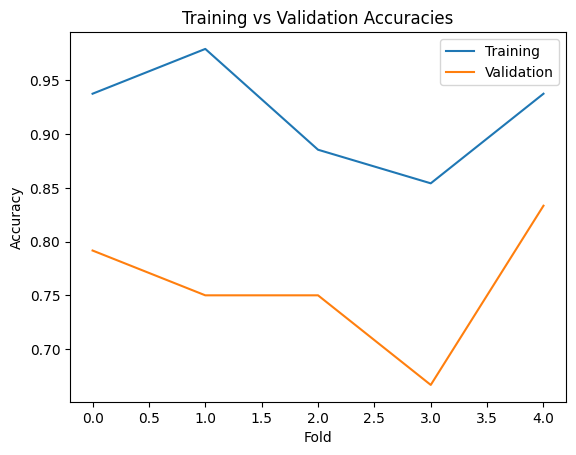

In [53]:
def plot_results(training_scores, validation_scores):
    plt.plot(training_scores, label='Training')
    plt.plot(validation_scores, label='Validation')
    plt.legend(loc='best')
    plt.title("Training vs Validation Accuracies")
    plt.xlabel('Fold') 
    plt.ylabel('Accuracy') 
    plt.show()
    
plot_results(training_scores, validation_scores)

### Test Adaboost F1 Score

In [54]:
# Algorithm F1 Score Result
training_scores, validation_scores, grid_result = evaluate_ada_hyperparameters(df_depression, seed, metric='f1')
grid_result.cv_results_

/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.747933 (0.071944) with: {'learning_rate': 0.8, 'n_estimators': 100}


{'mean_fit_time': array([0.11905794]),
 'std_fit_time': array([0.01235011]),
 'mean_score_time': array([0.01176858]),
 'std_score_time': array([0.00328081]),
 'param_learning_rate': masked_array(data=[0.8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.8, 'n_estimators': 100}],
 'split0_test_score': array([0.78711201]),
 'split1_test_score': array([0.75925926]),
 'split2_test_score': array([0.73951049]),
 'split3_test_score': array([0.61904762]),
 'split4_test_score': array([0.83473389]),
 'mean_test_score': array([0.74793265]),
 'std_test_score': array([0.0719445]),
 'rank_test_score': array([1], dtype=int32),
 'split0_train_score': array([0.93716677]),
 'split1_train_score': array([0.97977941]),
 'split2_train_score': array([0.88477461]),
 'split3_train_score': array([0.8476688]),
 'split4_tra

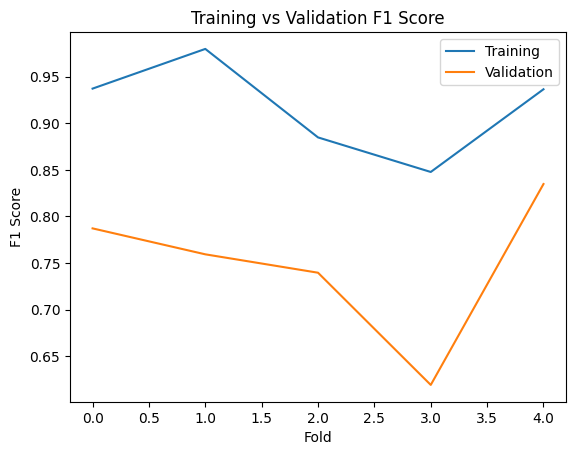

In [55]:
def plot_results(training_scores, validation_scores):
    plt.plot(training_scores, label='Training')
    plt.plot(validation_scores, label='Validation')
    plt.legend(loc='best')
    plt.title("Training vs Validation F1 Score")
    plt.xlabel('Fold') 
    plt.ylabel('F1 Score') 
    plt.show()
    
plot_results(training_scores, validation_scores)

### Test Adaboost Recall

In [56]:
# Algorithm Recall Result
training_scores, validation_scores, grid_result = evaluate_ada_hyperparameters(df_depression, seed, metric='recall')
grid_result.cv_results_

/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.791726 (0.039061) with: {'learning_rate': 0.8, 'n_estimators': 100}


{'mean_fit_time': array([0.13241491]),
 'std_fit_time': array([0.01252871]),
 'mean_score_time': array([0.01316843]),
 'std_score_time': array([0.0025391]),
 'param_learning_rate': masked_array(data=[0.8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.8, 'n_estimators': 100}],
 'split0_test_score': array([0.79444444]),
 'split1_test_score': array([0.78888889]),
 'split2_test_score': array([0.72857143]),
 'split3_test_score': array([0.79487179]),
 'split4_test_score': array([0.85185185]),
 'mean_test_score': array([0.79172568]),
 'std_test_score': array([0.03906137]),
 'rank_test_score': array([1], dtype=int32),
 'split0_train_score': array([0.93986928]),
 'split1_train_score': array([0.98095238]),
 'split2_train_score': array([0.88787879]),
 'split3_train_score': array([0.83749397]),
 'split4_tr

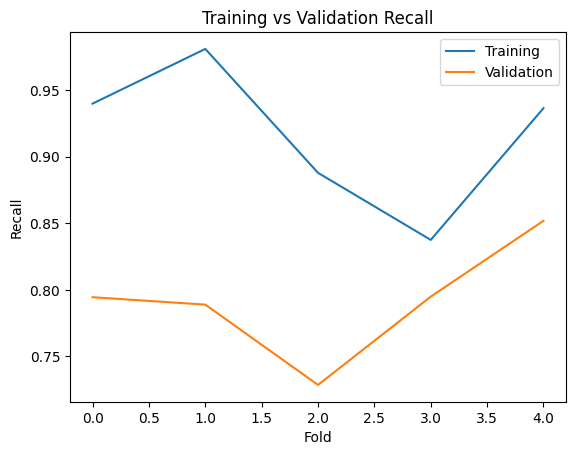

In [58]:
def plot_results(training_scores, validation_scores):
    plt.plot(training_scores, label='Training')
    plt.plot(validation_scores, label='Validation')
    plt.legend(loc='best')
    plt.title("Training vs Validation Recall")
    plt.xlabel('Fold') 
    plt.ylabel('Recall') 
    plt.show()
    
plot_results(training_scores, validation_scores)

## XGBoost

In [44]:
def run_xg_experiment(df_depression=df_depression,
                                  n_features=20,
                                  max_depth=1,
                                  n_estimators=152,
                                  learning_rate=0.4,
                                  subsample=0.83
                                  ):
    
    """
    Runs XGBoost with cross-validation. Returns a dataframe with average training accuracies, average validation accuracies, and average variance across folds

    Params:
        df_depression: dataframe with depression data
        n_features: number of features
        max_depth: weak learner tree depth
        n_estimators: number of trees
        learning_rate: learning rate
        subsample:fraction of observations used for each tree

    Returns:
        df_results: dataframe with results of experiment
    """
    
    # Print number of features used
    print(f"\nRunning experiment with {n_features} features, n estimators={n_estimators}, learning rate={learning_rate}, max depth={max_depth}, subsample={subsample}")
    print("-----------------------------------------------------------------------------------------")

    # Calculate column index for last feature
    last_feature_index = n_features + 1
    
    # Split the data into X and y
    X = np.array(df_depression.iloc[:, 1:last_feature_index])
    X_std = StandardScaler().fit_transform(X)
    y = np.array(df_depression.iloc[:, 0])

    # Define the evaluation procedure with k-fold cross-validation
    k_folds = 5
    cv = KFold(n_splits=k_folds, shuffle=True, random_state=1)

    # Create the logistic regression model with the best hyperparameters
    model = xgb.XGBClassifier(objective='multi:softprob',
                             max_depth=max_depth,
                             n_estimators=n_estimators,
                             learning_rate=learning_rate,
                             subsample=subsample,
                             )
    # Lists to store training and validation scores for each fold
    train_accuracies = []
    validation_accuracies = []

    # Perform cross-validation and get training and validation scores for each fold
    for train_index, validation_index in cv.split(X_std, y):
        X_train, X_val = X_std[train_index], X_std[validation_index]
        y_train, y_val = y[train_index], y[validation_index]

        # Train the model on the training set within each fold
        model.fit(X_train, y_train)

        # Calculate training and validation accuracies
        train_accuracy = model.score(X_train, y_train)
        validation_accuracy = model.score(X_val, y_val)

        # Append the accuracies to the lists
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)

        # Print the accuracy for the current fold
        print(f"Fold {len(train_accuracies)} - Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    # Calculate average training and validation accuracies
    average_training_accuracy = np.mean(train_accuracies)
    average_validation_accuracy = np.mean(validation_accuracies)
    average_variance = average_training_accuracy - average_validation_accuracy # Include as a measure of overfitting

    # Print the overall statistics
    print("Average Training Accuracy:", average_training_accuracy)
    print("Average Validation Accuracy:", average_validation_accuracy)

    # Create a dataframe containing results of the experiment
    df_results = pd.DataFrame({
        'n_features': [n_features],
        'n_estimators': [n_estimators],
        'learning rate': [learning_rate],
        'subsample': [subsample],
        'max_depth': [max_depth],
        'average_training_accuracy': [average_training_accuracy],
        'average_validation_accuracy': [average_validation_accuracy],
        'average_variance': [average_variance]
    })

    return df_results

In [45]:
# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['n_features', 'n_estimators', 'learning rate', 'subsample', 'max_depth', 'average_training_accuracy', 'average_validation_accuracy', 'average_variance'])

### Test number of features to include

In [46]:
# Run the experiment and store results in df_results
for num_features in [5, 10, 15, 20, 25, 30]:
    df_results = pd.concat([df_results, run_xg_experiment(n_features=num_features)], ignore_index=True)

df_results


Running experiment with 5 features, n estimators=152, learning rate=0.4, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 0.9792, Validation Accuracy: 0.6667
Fold 2 - Training Accuracy: 0.9896, Validation Accuracy: 0.6250
Fold 3 - Training Accuracy: 1.0000, Validation Accuracy: 0.4167
Fold 4 - Training Accuracy: 0.9896, Validation Accuracy: 0.7083
Fold 5 - Training Accuracy: 1.0000, Validation Accuracy: 0.5833
Average Training Accuracy: 0.9916666666666668
Average Validation Accuracy: 0.6

Running experiment with 10 features, n estimators=152, learning rate=0.4, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 1.0000, Validation Accuracy: 0.7917
Fold 2 - Training Accuracy: 1.0000, Validation Accuracy: 0.7917
Fold 3 - Training Accuracy: 1.0000, Validation Accuracy: 0.5833
Fold 4 - Training Accura

,n_features,n_estimators,learning rate,subsample,max_depth,average_training_accuracy,average_validation_accuracy,average_variance
0,5,152,0.4,0.83,1,0.991667,0.600000,0.391667
1,10,152,0.4,0.83,1,1.000000,0.691667,0.308333
2,15,152,0.4,0.83,1,1.000000,0.816667,0.183333
3,20,152,0.4,0.83,1,1.000000,0.800000,0.200000
4,25,152,0.4,0.83,1,1.000000,0.825000,0.175000
5,30,152,0.4,0.83,1,1.000000,0.791667,0.208333


25 features is optimal.

### Test n_estimators

In [47]:
# Run the experiment for n estimators hyperparameter and store results in df_results
for n_estimators in [100, 150, 300, 400]:
    df_results = pd.concat([df_results, run_xg_experiment(n_features=25, n_estimators = n_estimators)], ignore_index=True)

df_results


Running experiment with 25 features, n estimators=100, learning rate=0.4, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 1.0000, Validation Accuracy: 0.8333
Fold 2 - Training Accuracy: 1.0000, Validation Accuracy: 0.7917
Fold 3 - Training Accuracy: 1.0000, Validation Accuracy: 0.7500
Fold 4 - Training Accuracy: 1.0000, Validation Accuracy: 0.9167
Fold 5 - Training Accuracy: 1.0000, Validation Accuracy: 0.7500
Average Training Accuracy: 1.0
Average Validation Accuracy: 0.8083333333333332

Running experiment with 25 features, n estimators=150, learning rate=0.4, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 1.0000, Validation Accuracy: 0.8333
Fold 2 - Training Accuracy: 1.0000, Validation Accuracy: 0.7917
Fold 3 - Training Accuracy: 1.0000, Validation Accuracy: 0.7500
Fold 4 - Training Accur

,n_features,n_estimators,learning rate,subsample,max_depth,average_training_accuracy,average_validation_accuracy,average_variance
0,5,152,0.4,0.83,1,0.991667,0.600000,0.391667
1,10,152,0.4,0.83,1,1.000000,0.691667,0.308333
2,15,152,0.4,0.83,1,1.000000,0.816667,0.183333
3,20,152,0.4,0.83,1,1.000000,0.800000,0.200000
4,25,152,0.4,0.83,1,1.000000,0.825000,0.175000
5,30,152,0.4,0.83,1,1.000000,0.791667,0.208333
6,25,100,0.4,0.83,1,1.000000,0.808333,0.191667
7,25,150,0.4,0.83,1,1.000000,0.808333,0.191667
8,25,300,0.4,0.83,1,1.000000,0.816667,0.183333
9,25,400,0.4,0.83,1,1.000000,0.816667,0.183333


n_estimators = 152 is optimal.

### Test learning rate

In [48]:
# Run the experiment for learning rate hyperparameter and store results in df_results
for learning_rate in [0.1, 0.5, 1.3, 1.8, 2.0]:
    df_results = pd.concat([df_results, run_xg_experiment(n_features=25, n_estimators = 152, learning_rate = learning_rate)], ignore_index=True)

df_results


Running experiment with 25 features, n estimators=152, learning rate=0.1, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 1.0000, Validation Accuracy: 0.8333
Fold 2 - Training Accuracy: 0.9896, Validation Accuracy: 0.8333
Fold 3 - Training Accuracy: 1.0000, Validation Accuracy: 0.7917
Fold 4 - Training Accuracy: 1.0000, Validation Accuracy: 0.9167
Fold 5 - Training Accuracy: 1.0000, Validation Accuracy: 0.7500
Average Training Accuracy: 0.9979166666666668
Average Validation Accuracy: 0.825

Running experiment with 25 features, n estimators=152, learning rate=0.5, max depth=1, subsample=0.83
-----------------------------------------------------------------------------------------
Fold 1 - Training Accuracy: 1.0000, Validation Accuracy: 0.7917
Fold 2 - Training Accuracy: 1.0000, Validation Accuracy: 0.7917
Fold 3 - Training Accuracy: 1.0000, Validation Accuracy: 0.7917
Fold 4 - Training Acc

,n_features,n_estimators,learning rate,subsample,max_depth,average_training_accuracy,average_validation_accuracy,average_variance
0,5,152,0.4,0.83,1,0.991667,0.600000,0.391667
1,10,152,0.4,0.83,1,1.000000,0.691667,0.308333
2,15,152,0.4,0.83,1,1.000000,0.816667,0.183333
3,20,152,0.4,0.83,1,1.000000,0.800000,0.200000
4,25,152,0.4,0.83,1,1.000000,0.825000,0.175000
5,30,152,0.4,0.83,1,1.000000,0.791667,0.208333
6,25,100,0.4,0.83,1,1.000000,0.808333,0.191667
7,25,150,0.4,0.83,1,1.000000,0.808333,0.191667
8,25,300,0.4,0.83,1,1.000000,0.816667,0.183333
9,25,400,0.4,0.83,1,1.000000,0.816667,0.183333


0.1 learning rate seems optimal, although 0.4 is close.

Ablation studies suggest that the optimal hyperparameters are:

- n_features = 25
- learning rate = 0.1 / 0.4
- n_estimators = 152


### XG Gridsearch

In [49]:
def run_xg_grid_search(df_depression=df_depression, n_features=25):
    """
    Conducts grid search using adaboost regression with K-fold cross-validation for different n_features.

    Params:
        df_depression: dataframe with depression data
        n_features: number of features to use

    Returns:
        grid_search_results: a dictionary containing the best hyperparameters and corresponding accuracy
        cv_results_df: a pandas dataframe containing the cross-validation results
    """

    # Calculate column index for last feature
    last_feature_index = n_features + 1
    
    # Split the data into X and y
    X = np.array(df_depression.iloc[:, 1:last_feature_index])
    X_std = StandardScaler().fit_transform(X)
    y = np.array(df_depression.iloc[:, 0])

    # Define the logistic regression model
    model = xgb.XGBClassifier(objective='multi:softprob')

    best_params_list = []
    best_accuracy_list = []

    # Define the hyperparameter grid
    param_grid = {
        'learning_rate': [0.1, 0.4, 0.8],
        'n_estimators': [100, 400, 152],
        'subsample': [0.1, 0.4]
    }

    # define k-fold cross-validation experimentation
    k_folds = 5
    cv = KFold(n_splits=k_folds, shuffle=True, random_state=1)

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=cv, return_train_score=True)

    # Perform grid search on the data for the current number of features
    grid_search.fit(X_std, y)

    # Convert cv_results_ to a pandas DataFrame
    cv_results_df = pd.DataFrame(grid_search.cv_results_)

    # Remove rows from cv_results_ that have NaN mean_test_score
    cv_results_df = cv_results_df[cv_results_df['mean_test_score'].notna()]

    # Calculate mean variance (difference between test and train) for each hyperparameter combination
    cv_results_df['mean_variance'] = cv_results_df['mean_train_score'] - cv_results_df['mean_test_score']

    # Keep only the columns of interest
    cv_results_df = cv_results_df[['param_learning_rate', 'param_n_estimators', 'mean_train_score', 'mean_test_score', 'mean_variance']]

    # Sort cv_results_ by mean_test_score and reindex
    cv_results_df = cv_results_df.sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)

    return cv_results_df

# Call the function and store the results
df_xg_gridsearch = run_xg_grid_search()

# Output the results
print("Grid Search Results (Sorted by test_score):")
display(df_xg_gridsearch)

# Print the best hyperparameters
print("Best Hyperparameters:")
display(df_xg_gridsearch.iloc[0, 0:3])

Grid Search Results (Sorted by test_score):


,param_learning_rate,param_n_estimators,mean_train_score,mean_test_score,mean_variance
0,0.8,400,1.000000,0.866667,0.133333
1,0.8,152,1.000000,0.858333,0.141667
2,0.1,152,1.000000,0.858333,0.141667
3,0.4,100,1.000000,0.850000,0.150000
4,0.1,100,0.877083,0.850000,0.027083
5,0.1,400,1.000000,0.850000,0.150000
6,0.1,400,0.912500,0.850000,0.062500
7,0.4,400,1.000000,0.850000,0.150000
8,0.1,152,0.900000,0.841667,0.058333
9,0.1,100,0.995833,0.841667,0.154167


Best Hyperparameters:


param_learning_rate    0.8
param_n_estimators     400
mean_train_score       1.0
Name: 0, dtype: object

Our ablation analysis returned the 3rd best model according to grid search. The top ranked set of hyperparameters achieves a validation score much higher and variance mcuh lower than the results of the ablation analysis. We will proceed with these hyperparameters:

- n_features = 25
- learning rate = 0.8
- n_estimators = 400

In [59]:
def run_xg(df_depression, seed, metric='accuracy'):

    #use first 20 columns as features and the last column as the target
    X = np.array(df_depression.iloc[:, 1:26])
    y = np.array(df_depression.iloc[:, 0])
    
    X_std = StandardScaler().fit_transform(X)
    model = xgb.XGBClassifier(objective='multi:softprob')
    
    grid = {
        'n_estimators': [400],
        'max_depth': [1],
        'learning_rate': [0.8],
        'subsample': [0.83089]
    }
    
    # Update scoring based on desired metric
    if metric == 'f1':
        scoring_val = 'f1_macro'
    elif metric == 'recall':
        scoring_val = 'recall_macro'
    else:
        scoring_val = 'accuracy'
    
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoring_val, return_train_score=True)
    grid_result = grid_search.fit(X_std, y)
    
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    training_scores = []
    validation_scores = []
    for train_index, val_index in cv.split(X_std, y):
        X_train, X_val = X_std[train_index], X_std[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.set_params(**grid_result.best_params_)
        model.fit(X_train, y_train)
        
        if metric == 'f1':
            train_score = f1_score(y_train, model.predict(X_train), average='macro')
            val_score = f1_score(y_val, model.predict(X_val), average='macro')
        elif metric == 'recall':
            train_score = recall_score(y_train, model.predict(X_train), average='macro')
            val_score = recall_score(y_val, model.predict(X_val), average='macro')
        else:
            train_score = model.score(X_train, y_train)
            val_score = model.score(X_val, y_val)

        training_scores.append(train_score)
        validation_scores.append(val_score)
        
    return training_scores, validation_scores, grid_result


### Testing XGBoost Accuracy

In [60]:
#Algorithm Accuracy Result
seed = 42
training_scores, validation_scores, grid_resultxg = run_xg(df_depression, seed)
grid_resultxg.cv_results_

{'mean_fit_time': array([0.09982066]),
 'std_fit_time': array([0.01215845]),
 'mean_score_time': array([0.00158539]),
 'std_score_time': array([0.00011931]),
 'param_learning_rate': masked_array(data=[0.8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[400],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.83089],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.8,
   'max_depth': 1,
   'n_estimators': 400,
   'subsample': 0.83089}],
 'split0_test_score': array([0.79166667]),
 'split1_test_score': array([0.875]),
 'split2_test_score': array([0.83333333]),
 'split3_test_score': array([0.91666667]),
 'split4_test_score': array([0.79166667]),
 'mean_test_score'

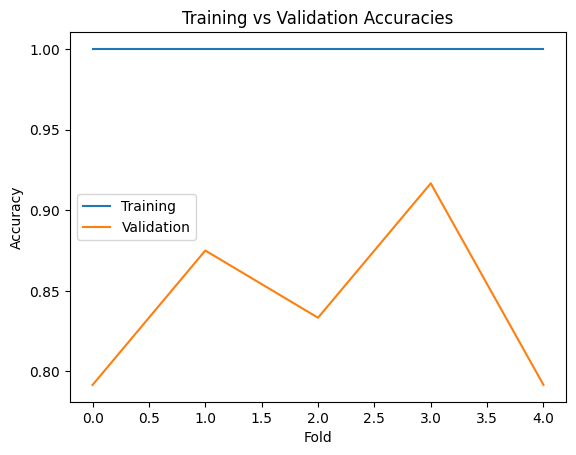

In [61]:
def plot_results(training_scores, validation_scores):
    plt.plot(training_scores, label='Training')
    plt.plot(validation_scores, label='Validation')
    plt.legend(loc='best')
    plt.title("Training vs Validation Accuracies")
    plt.xlabel('Fold') 
    plt.ylabel('Accuracy') 
    plt.show()
    
plot_results(training_scores, validation_scores)

### Testing XGBoost F1 Score

In [63]:
#Algorithm F1 Score Result
seed = 42
training_scores, validation_scores, grid_resultxg = run_xg(df_depression, seed, metric='f1')
grid_resultxg.cv_results_

{'mean_fit_time': array([0.09240975]),
 'std_fit_time': array([0.01924196]),
 'mean_score_time': array([0.00215859]),
 'std_score_time': array([0.00015606]),
 'param_learning_rate': masked_array(data=[0.8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[400],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.83089],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.8,
   'max_depth': 1,
   'n_estimators': 400,
   'subsample': 0.83089}],
 'split0_test_score': array([0.77743378]),
 'split1_test_score': array([0.88002835]),
 'split2_test_score': array([0.83682984]),
 'split3_test_score': array([0.8880117]),
 'split4_test_score': array([0.79497354]),
 'mean_test_sc

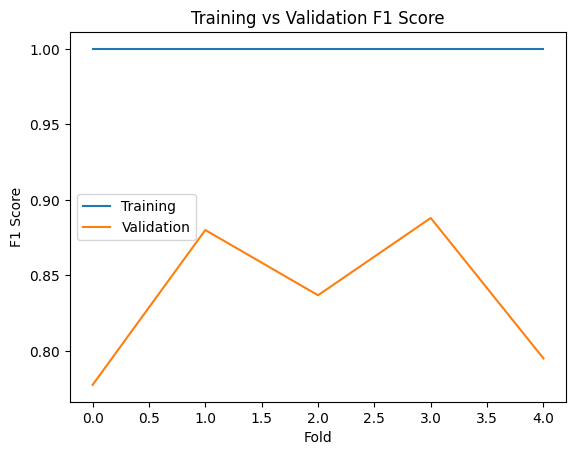

In [64]:
def plot_results(training_scores, validation_scores):
    plt.plot(training_scores, label='Training')
    plt.plot(validation_scores, label='Validation')
    plt.legend(loc='best')
    plt.title("Training vs Validation F1 Score")
    plt.xlabel('Fold') 
    plt.ylabel('F1 Score') 
    plt.show()
    
plot_results(training_scores, validation_scores)

### Testing XGBoost Recall

In [66]:
#Algorithm Recall Result
seed = 42
training_scores, validation_scores, grid_resultxg = run_xg(df_depression, seed, metric='recall')
grid_resultxg.cv_results_

{'mean_fit_time': array([0.11218314]),
 'std_fit_time': array([0.01186393]),
 'mean_score_time': array([0.00191779]),
 'std_score_time': array([0.00019279]),
 'param_learning_rate': masked_array(data=[0.8],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[400],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.83089],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.8,
   'max_depth': 1,
   'n_estimators': 400,
   'subsample': 0.83089}],
 'split0_test_score': array([0.78055556]),
 'split1_test_score': array([0.8962963]),
 'split2_test_score': array([0.82380952]),
 'split3_test_score': array([0.94871795]),
 'split4_test_score': array([0.81481481]),
 'mean_test_sc

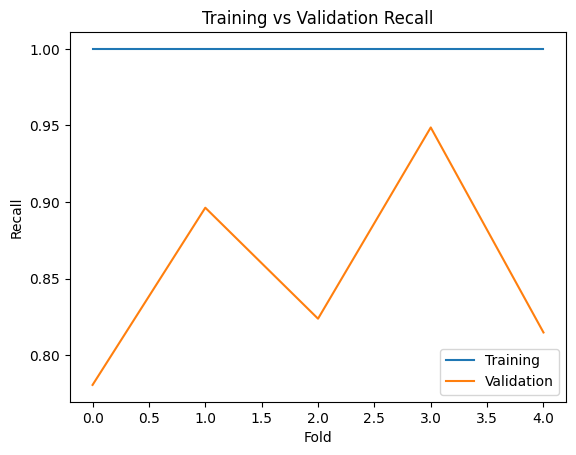

In [67]:
def plot_results(training_scores, validation_scores):
    plt.plot(training_scores, label='Training')
    plt.plot(validation_scores, label='Validation')
    plt.legend(loc='best')
    plt.title("Training vs Validation Recall")
    plt.xlabel('Fold') 
    plt.ylabel('Recall') 
    plt.show()
    
plot_results(training_scores, validation_scores)

## Deep Neural Networks

### Input Data

In [68]:
#read activity data
df=pd.read_csv('../data/processed/data_augmented.csv')

### Align activity data
Trim acitivity data to ensure that each time series has the same time duration so that they can be analyzed together. 

In [ ]:
def align_timeseries(df,df2):
    
    df_join=pd.merge(df[['number','activity','timestamp']],df2,on='number')

    the_range=np.arange(10080)
    the_array=np.tile(the_range,int(df_join.shape[0]/10080))
    df_join.timestamp=the_array

    # Create separate DataFrames
    df_activity = df_join[['number', 'activity','timestamp']].pivot(index='number', columns='timestamp',values=['activity']).reset_index()
    df_activity.columns = df_activity.columns.droplevel(0)
    df_activity.rename(columns={'':'number'},inplace=True)

    # Single input features
    single_feature_names = ['activity_entropy_hourly', 'activity_entropy_minutely',
           'activity_intraday_variability', 'activity_kurtosis_daily',
           'activity_kurtosis_hourly', 'activity_kurtosis_minutely',
           'activity_mean', 'activity_mean_weekdays_0to6',
           'activity_mean_weekdays_6to12', 'activity_mean_weekends_0to6',
           'activity_mean_weekends_12to18', 'activity_mean_weekends_6to12',
           'activity_pct_0to6', 'activity_pct_12to18', 'activity_pct_18to0',
           'activity_pct_6to12', 'activity_pct_weekday', 'activity_skewness_daily',
           'activity_skewness_hourly', 'activity_skewness_minutely',
           'activity_std_hourly', 'bout_act_dur_kurtosis', 'bout_act_dur_std',
           'bout_act_num', 'bout_inact_dur_cv', 'bout_inact_dur_entropy',
           'bout_inact_dur_mean', 'bout_inact_dur_std',
           'cos_day_of_week_amplitude', 'cos_minute_of_day_phase']

    # Create single value input df
    df_single_value_inputs = df_join[['number'] + single_feature_names].drop_duplicates().reset_index(drop=True)

    # Outcome
    df_outcome = df_join[['number', 'madrs2_grouped']].drop_duplicates().reset_index(drop=True)

    # Merge
    df_combined = pd.merge(df_activity, df_single_value_inputs, on='number')
    df_combined = pd.merge(df_combined, df_outcome, on='number').reset_index(drop=True)
    
    # Ensure it is ordered consistent with other models
    df_combined = df_combined.set_index('number')
    df_combined = df_combined.loc[df_features['number']]
    df_combined.reset_index(inplace=True)
    
    return df_combined,single_feature_names


### aggregate time-series
Each sample in our dataset comprises a time series with a length of 10,080 data points. Given the substantial size of these time series, there was some uncertainty regarding the performance of Long Short-Term Memory (LSTM) models. To mitigate potential issues and streamline the data, an aggregation strategy was employed, wherein the maximum value for each hour was extracted.

Note: The peaks do not visually align as the condensed data is stretched out for the graph.


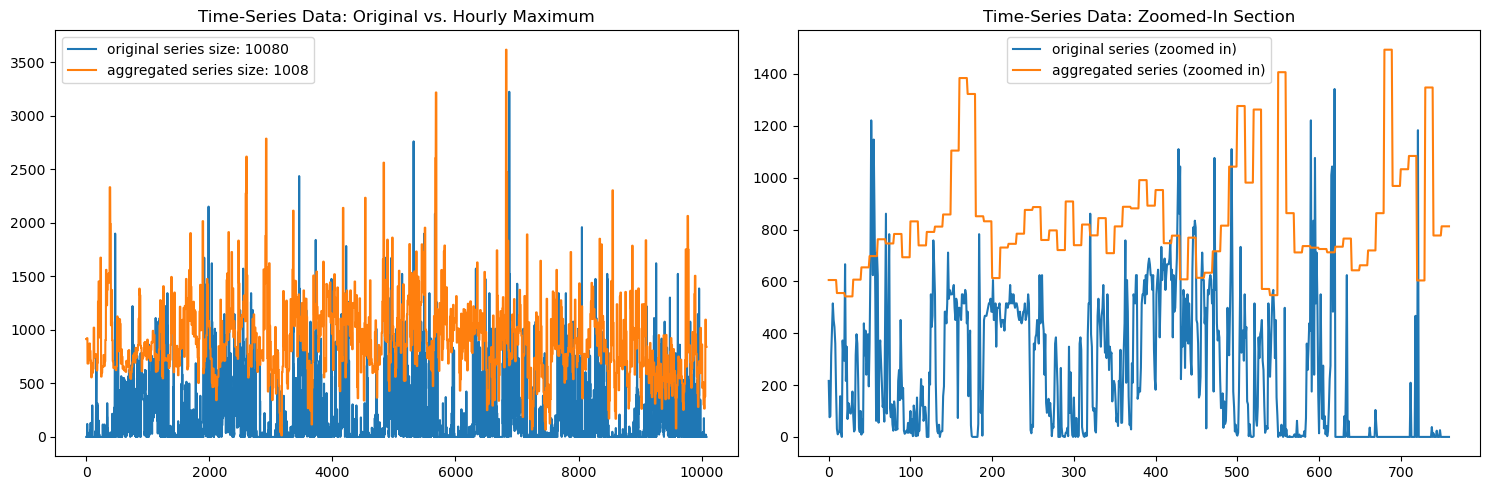

In [ ]:
# Reduce activity timeseries by taking 10 minute segment maximums for LSTM layers analysis
def condense_activity_data_plots(minutes,samp_num):

    df_combined,single_feature_names=align_timeseries(pd.read_csv('../data/processed/data_augmented.csv'),df_features)

    # Reshape and process the activity data
    activity_data = df_combined.loc[:, (0):10079].values.reshape((120, -1))
    reshaped_data = np.array(activity_data).reshape(120, 7, minutes, -1)
    averaged_data = np.mean(reshaped_data, axis=2)
    max_data = np.max(reshaped_data, axis=2)
    averaged_data=averaged_data+max_data
    stretched_data = np.repeat(averaged_data, minutes, axis=2)
    activity_data_stretched = stretched_data.reshape(120, -1, 1)
    act_size = 7 * reshaped_data.shape[3]

    # Create a figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the original and stretched series on the first subplot
    ax1.plot(activity_data[samp_num], label='original series size: 10080')
    ax1.plot(activity_data_stretched[samp_num], label=(f'aggregated series size: {act_size}'))
    ax1.legend()
    ax1.set_title("Time-Series Data: Original vs. Hourly Maximum")

    # Plot a zoomed-in section on the second subplot
    zoom_start = 700
    zoom_end = 700+60
    ax2.plot(activity_data[samp_num, zoom_start:zoom_start + zoom_end], label='original series (zoomed in)')
    ax2.plot(activity_data_stretched[samp_num, zoom_start:zoom_start + zoom_end], label=(f'aggregated series (zoomed in)'))
    ax2.legend()
    ax2.set_title("Time-Series Data: Zoomed-In Section")

    # Show the plots
    plt.tight_layout()
    print('Note: The peaks do not visually align as the condensed data is stretched out for the graph.')
    plt.show()


minutes = 10
samp_num = 25
act_size=condense_activity_data_plots(minutes,samp_num)

In [ ]:
#performance graphs
def graph_nn_results(num,history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Iterate over history to plot loss
    for hist in history:
        axes[0].plot(hist.history['loss'])
    axes[0].set_title('K-Folds Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    # Iterate over history to compute average accuracy
    avg_train_acc = [0] * epochs  
    avg_val_acc = [0] * epochs
    for h in history:
        for i in range(epochs):
            avg_train_acc[i] += h.history['accuracy'][i]
            avg_val_acc[i] += h.history['val_accuracy'][i]
    for i in range(epochs):
        avg_train_acc[i] /= n_splits
        avg_val_acc[i] /= n_splits

    # Plot average accuracy
    axes[1].plot(range(1, epochs+1), avg_train_acc, label='Average Training Accuracy')  
    axes[1].plot(range(1, epochs+1), avg_val_acc, label='Average Validation Accuracy') 
    axes[1].set_title('Average K-Fold Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Display the plot
    print(f'K-Fold mean accuracy: {round(np.mean(results),3)}')
    fig.suptitle(f'Model {num} Performance: Loss and Accuracy', fontsize=16)
    plt.tight_layout()
    plt.show()

### RNN - Long Short-Term Memory (LSTM) model
The initial model leverages Long Short-Term Memory (LSTM) layers to perform classification of depression. It seeks to accomplish this task solely by discerning patterns within the aggregated time-series data of patient activity.

I read that conventional wisdom often cautions against using too many LSTM layers, typically limiting them to a maximum of three. Initially, I adhered to this guidance, but when I experimented with adding more layers, I observed a slight increase in performance. This improvement may be attributable to the complexity and length of the timeseries data, which likely requires more layers to detect nuanced patterns. However, too many layers had an inverse, negative impact.

In [ ]:
#create df for RNN model ablation
df_results = pd.DataFrame({
    'LSTM_Layers': [],
    'Drop_Outs':[],
    'epochs': [],
    'batch_size':[],
    'learn_rate': [],
    'average_training_accuracy': [],
    'average_validation_accuracy': [],
    'average_variance': []
})

In [ ]:
def rnn_model_run(minutes,samp_num,df_results,act_size, seed):
    
    #get data
    df_combined,single_feature_names=align_timeseries(pd.read_csv('../data/processed/data_augmented.csv'),df_features)
    
    # Parameters
    results=[]
    lstms=[[128, 128, 64, 64, 64, 32, 32, 32,16,8]]
    node=[[0.4, 0.5, 0.4, 0.4, 0.4, 0.4, 0.4,.4,.2]]
    epochs=49
    batch_size=32
    lr=.0002
    folds=5
    num_classes=3

    # Function to create the model
    def create_model_1(l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,n1,n2,n3,n4,n5,n6,n7,n8,n9):
        # input layers for the timeseries
        act_max = tf.keras.layers.Input(shape=(act_size, 1), name='activity_max')

        # LSTM layers for max activity
        lstm1_max = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=l1, activation='tanh', return_sequences=True), name='lstm1_max')(act_max)
        dropout1_max = tf.keras.layers.Dropout(n1)(lstm1_max)
        lstm2_max = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=l2, activation='tanh', return_sequences=True), name='lstm2_max')(dropout1_max)
        dropout2_max = tf.keras.layers.Dropout(n2)(lstm2_max)
        lstm3_max = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=l3, activation='tanh', return_sequences=True), name='lstm3_max')(dropout2_max)
        dropout3_max = tf.keras.layers.Dropout(n3)(lstm3_max)
        lstm4_max = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=l4, activation='tanh', return_sequences=True), name='lstm4_max')(dropout3_max)
        dropout4_max = tf.keras.layers.Dropout(n4)(lstm4_max)
        lstm5_max = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=l5, activation='tanh', return_sequences=True), name='lstm5_max')(dropout4_max)

        dropout5_max = tf.keras.layers.Dropout(n5)(lstm5_max)
        lstm6_max = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=l6, activation='tanh', return_sequences=True), name='lstm6_max')(dropout5_max)
        dropout6_max = tf.keras.layers.Dropout(n6)(lstm6_max)
        lstm7_max = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=l7, activation='tanh', return_sequences=True), name='lstm7_max')(dropout6_max)
        dropout7_max = tf.keras.layers.Dropout(n7)(lstm7_max)
        lstm8_max = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=l8, activation='tanh', return_sequences=True), name='lstm8_max')(dropout7_max)
        dropout8_max = tf.keras.layers.Dropout(n8)(lstm8_max)
        lstm9_max = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=l9, activation='tanh', return_sequences=True), name='lstm9_max')(dropout8_max)
        dropout9_max = tf.keras.layers.Dropout(n9)(lstm9_max)
        lstm10_max = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=l10, activation='tanh', return_sequences=False), name='lstm10_max')(dropout9_max)

        
        #output layer for the final prediction
        logits = tf.keras.layers.Dense(units=3, activation='softmax', name='logits')(lstm10_max)

        #create final model by specifying inputs and outputs
        model1 = tf.keras.models.Model(inputs=[act_max], outputs=logits)

        return model1

    # Prepare dataset
    activity_data_max = df_combined.loc[:,(0):10079].values.reshape((120, -1))
    reshaped_data_max = np.array(activity_data_max).reshape(120, 7, minutes, -1)
    averaged_data = np.mean(reshaped_data_max, axis=2)
    averaged_max = np.max(reshaped_data_max, axis=2)
    averaged_data_max=averaged_max+averaged_data
    activity_data_max = averaged_data_max.reshape(120, -1,1)
    labels = np.array(df_combined.madrs2_grouped)
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    y_data = tf.keras.utils.to_categorical(encoded_labels, num_classes=num_classes)

    # KFold Cross-validation
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    histories=[]

    for a, l in enumerate(lstms):
        history_fold = []
        for train_index, test_index in kf.split(activity_data_max):
            x_train = {
                'activity_max': activity_data_max[train_index],
            }
            y_train = y_data[train_index]

            x_test = {
                'activity_max': activity_data_max[test_index],
            }
            y_test = y_data[test_index]

            #standardize
            scaler = StandardScaler()

            #standardization for the time series
            scaler_ts = StandardScaler()
            x_train_max_flat = x_train['activity_max'].reshape((x_train['activity_max'].shape[0]*x_train['activity_max'].shape[1], x_train['activity_max'].shape[2]))
            x_train_max_flat = scaler_ts.fit_transform(x_train_max_flat)
            x_train['activity_max'] = x_train_max_flat.reshape((x_train['activity_max'].shape[0], x_train['activity_max'].shape[1], x_train['activity_max'].shape[2]))

            x_test_max_flat = x_test['activity_max'].reshape((x_test['activity_max'].shape[0]*x_test['activity_max'].shape[1], x_test['activity_max'].shape[2]))
            x_test_max_flat = scaler_ts.transform(x_test_max_flat)
            x_test['activity_max'] = x_test_max_flat.reshape((x_test['activity_max'].shape[0], x_test['activity_max'].shape[1], x_test['activity_max'].shape[2]))

            #compile and train the model
            model1 = create_model_1(l[0],l[1],l[2],l[3],l[4],l[5],l[6],l[7],l[8],l[9],\
                                    node[a][0],node[a][1],node[a][2],node[a][3],node[a][4],\
                                    node[a][5],node[a][6],node[a][7],node[a][8]) 
            model1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
                   loss='categorical_crossentropy',
                   metrics=[
                       'accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')
                   ])

            history=(model1.fit(
                x=x_train['activity_max'],
                y=y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test['activity_max'], y_test),
                verbose=1
            ))
            history_fold.append(history)
        histories.append(history_fold)

        #calculate average accuracy, precision, recall, and F1 score across all folds
        train_acc = np.mean([h.history['accuracy'][-1] for h in history_fold])
        accuracy_per_fold = [h[0].history['val_accuracy'][-1] for h in histories]
        precision_per_fold = [h[0].history['precision'][-1] for h in histories]
        recall_per_fold = [h[0].history['recall'][-1] for h in histories]
        epsilon = 1e-7  # A small epsilon value to avoid division by zero
        f1_per_fold = [2 * (precision * recall) / (precision + recall + epsilon) for precision, recall in zip(precision_per_fold, recall_per_fold)]

        average_accuracy = sum(accuracy_per_fold) / len(accuracy_per_fold)
        average_precision = sum(precision_per_fold) / len(precision_per_fold)
        average_recall = sum(recall_per_fold) / len(recall_per_fold)
        average_f1 = sum(f1_per_fold) / len(f1_per_fold)

        results.append((average_accuracy))
        print('Average validation accuracy:', average_accuracy)
        print('Average validation precision:', average_precision)
        print('Average validation recall:', average_recall)
        print('Average validation F1 score:', average_f1)
              
        #convert the lists to comma-separated strings
        lstms_str = ','.join(map(str, lstms[a]))
        node_str = ','.join(map(str, node[a]))
        
        #add results to DataFrame  
        df_results.loc[len(df_results.index)]=\
        [lstms_str, node_str, epochs, batch_size, lr, train_acc, average_accuracy, train_acc - average_accuracy]
        
        return df_results

df_results=rnn_model_run(minutes,samp_num,df_results,act_size, seed)

Epoch 1/49
3/3 [==============================] - 22s 5s/step - loss: 1.0960 - accuracy: 0.3646 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0905 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/49
3/3 [==============================] - 11s 4s/step - loss: 1.0857 - accuracy: 0.4479 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0829 - val_accuracy: 0.4583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/49
3/3 [==============================] - 11s 4s/step - loss: 1.0750 - accuracy: 0.4375 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0745 - val_accuracy: 0.4583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/49
3/3 [==============================] - 11s 4s/step - loss: 1.0674 - accuracy: 0.4167 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0671 - val_accuracy: 0.4167 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/49
3/3 [==============================] - 11s 4s

3/3 [==============================] - 11s 4s/step - loss: 0.7049 - accuracy: 0.8125 - precision: 0.8659 - recall: 0.7396 - val_loss: 1.0131 - val_accuracy: 0.5833 - val_precision: 0.5455 - val_recall: 0.5000
Epoch 38/49
3/3 [==============================] - 11s 4s/step - loss: 0.7010 - accuracy: 0.8125 - precision: 0.8353 - recall: 0.7396 - val_loss: 1.0215 - val_accuracy: 0.5833 - val_precision: 0.5238 - val_recall: 0.4583
Epoch 39/49
3/3 [==============================] - 11s 4s/step - loss: 0.6878 - accuracy: 0.8021 - precision: 0.8519 - recall: 0.7188 - val_loss: 1.0246 - val_accuracy: 0.5417 - val_precision: 0.5000 - val_recall: 0.4583
Epoch 40/49
3/3 [==============================] - 11s 4s/step - loss: 0.6829 - accuracy: 0.8125 - precision: 0.8519 - recall: 0.7188 - val_loss: 1.0295 - val_accuracy: 0.5417 - val_precision: 0.4762 - val_recall: 0.4167
Epoch 41/49
3/3 [==============================] - 11s 4s/step - loss: 0.6817 - accuracy: 0.8021 - precision: 0.8608 - recall: 0

Epoch 25/49
3/3 [==============================] - 11s 4s/step - loss: 0.7861 - accuracy: 0.7083 - precision: 0.7848 - recall: 0.6458 - val_loss: 0.8286 - val_accuracy: 0.7083 - val_precision: 0.6957 - val_recall: 0.6667
Epoch 26/49
3/3 [==============================] - 11s 4s/step - loss: 0.7490 - accuracy: 0.6979 - precision: 0.8169 - recall: 0.6042 - val_loss: 0.7899 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 27/49
3/3 [==============================] - 11s 4s/step - loss: 0.7633 - accuracy: 0.7188 - precision: 0.8060 - recall: 0.5625 - val_loss: 0.7845 - val_accuracy: 0.7917 - val_precision: 0.8182 - val_recall: 0.7500
Epoch 28/49
3/3 [==============================] - 11s 4s/step - loss: 0.7478 - accuracy: 0.7292 - precision: 0.7975 - recall: 0.6562 - val_loss: 0.7870 - val_accuracy: 0.7917 - val_precision: 0.7917 - val_recall: 0.7917
Epoch 29/49
3/3 [==============================] - 11s 4s/step - loss: 0.7457 - accuracy: 0.7500 - precision: 0.7901

3/3 [==============================] - 12s 4s/step - loss: 1.0066 - accuracy: 0.5312 - precision: 0.7143 - recall: 0.0521 - val_loss: 1.0411 - val_accuracy: 0.5000 - val_precision: 0.7143 - val_recall: 0.2083
Epoch 13/49
3/3 [==============================] - 11s 4s/step - loss: 0.9949 - accuracy: 0.5417 - precision: 0.7692 - recall: 0.1042 - val_loss: 1.0409 - val_accuracy: 0.5000 - val_precision: 0.7143 - val_recall: 0.2083
Epoch 14/49
3/3 [==============================] - 11s 4s/step - loss: 0.9975 - accuracy: 0.4896 - precision: 0.6923 - recall: 0.0938 - val_loss: 1.0392 - val_accuracy: 0.5000 - val_precision: 0.7143 - val_recall: 0.2083
Epoch 15/49
3/3 [==============================] - 11s 4s/step - loss: 0.9907 - accuracy: 0.5208 - precision: 0.8000 - recall: 0.1250 - val_loss: 1.0328 - val_accuracy: 0.5417 - val_precision: 0.7143 - val_recall: 0.2083
Epoch 16/49
3/3 [==============================] - 11s 4s/step - loss: 0.9888 - accuracy: 0.5208 - precision: 0.7222 - recall: 0

3/3 [==============================] - 11s 4s/step - loss: 0.6714 - accuracy: 0.7917 - precision: 0.8313 - recall: 0.7188 - val_loss: 0.8160 - val_accuracy: 0.7500 - val_precision: 0.7727 - val_recall: 0.7083
Epoch 1/49
3/3 [==============================] - 22s 5s/step - loss: 1.0990 - accuracy: 0.3438 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0974 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/49
3/3 [==============================] - 11s 4s/step - loss: 1.0877 - accuracy: 0.4792 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0949 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/49
3/3 [==============================] - 11s 4s/step - loss: 1.0785 - accuracy: 0.4688 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0929 - val_accuracy: 0.2917 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/49
3/3 [==============================] - 11s 4s/step - loss: 1.0720 - accu

Epoch 37/49
3/3 [==============================] - 11s 4s/step - loss: 0.7739 - accuracy: 0.7500 - precision: 0.8235 - recall: 0.5833 - val_loss: 0.8732 - val_accuracy: 0.6667 - val_precision: 0.6842 - val_recall: 0.5417
Epoch 38/49
3/3 [==============================] - 11s 4s/step - loss: 0.7762 - accuracy: 0.7292 - precision: 0.8030 - recall: 0.5521 - val_loss: 0.8749 - val_accuracy: 0.6667 - val_precision: 0.7647 - val_recall: 0.5417
Epoch 39/49
3/3 [==============================] - 11s 4s/step - loss: 0.7548 - accuracy: 0.7708 - precision: 0.8382 - recall: 0.5938 - val_loss: 0.8262 - val_accuracy: 0.6250 - val_precision: 0.8125 - val_recall: 0.5417
Epoch 40/49
3/3 [==============================] - 11s 4s/step - loss: 0.7581 - accuracy: 0.7500 - precision: 0.8451 - recall: 0.6250 - val_loss: 0.8293 - val_accuracy: 0.6667 - val_precision: 0.6842 - val_recall: 0.5417
Epoch 41/49
3/3 [==============================] - 11s 4s/step - loss: 0.7388 - accuracy: 0.7812 - precision: 0.8676

3/3 [==============================] - 11s 4s/step - loss: 0.8619 - accuracy: 0.6042 - precision: 0.7458 - recall: 0.4583 - val_loss: 1.0624 - val_accuracy: 0.4583 - val_precision: 0.5000 - val_recall: 0.2500
Epoch 25/49
3/3 [==============================] - 11s 4s/step - loss: 0.8481 - accuracy: 0.6354 - precision: 0.7719 - recall: 0.4583 - val_loss: 1.0499 - val_accuracy: 0.5417 - val_precision: 0.5000 - val_recall: 0.2500
Epoch 26/49
3/3 [==============================] - 11s 4s/step - loss: 0.8438 - accuracy: 0.6562 - precision: 0.7500 - recall: 0.4375 - val_loss: 1.0432 - val_accuracy: 0.5417 - val_precision: 0.6000 - val_recall: 0.2500
Epoch 27/49
3/3 [==============================] - 11s 4s/step - loss: 0.8361 - accuracy: 0.6771 - precision: 0.8113 - recall: 0.4479 - val_loss: 1.0406 - val_accuracy: 0.4583 - val_precision: 0.6000 - val_recall: 0.2500
Epoch 28/49
3/3 [==============================] - 11s 4s/step - loss: 0.8310 - accuracy: 0.6771 - precision: 0.8333 - recall: 0

K-Fold mean accuracy: 0.542


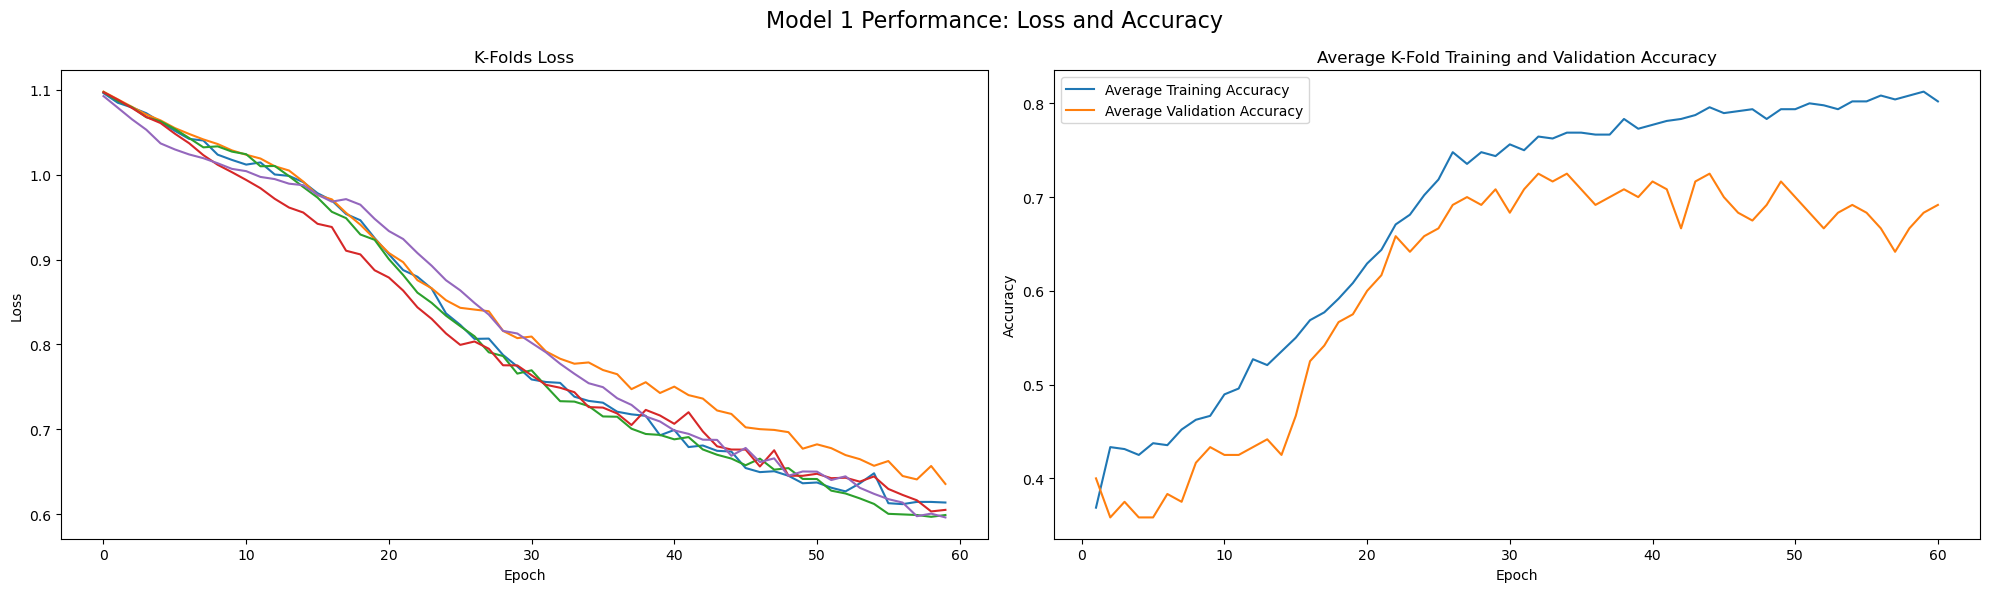

In [ ]:
#visual analysis of results
graph_nn_results(1,histories[0])

In [ ]:
#ablation table
df_results

,LSTM_Layers,Drop_Outs,epochs,batch_size,learn_rate,average_training_accuracy,average_validation_accuracy,average_variance
0,"256,128","0.1, 0.2, 0.2",20,32,0.00200,0.700000,0.450000,0.250000
1,"256,128,64","0.1, 0.2, 0.2",40,32,0.00002,0.480000,0.460000,0.020000
2,"128,128,64","0.4, 0.4, 0.3",20,32,0.00010,0.800000,0.570000,0.230000
3,"128,64,32","0.2, 0.2, 0.2",20,32,0.00010,0.500000,0.400000,0.100000
4,"64, 64, 64","0.4, 0.4, 0.3",70,32,0.00010,0.741667,0.575000,0.166667
5,"64, 32, 32","0.4, 0.4, 0.3",70,32,0.00010,0.697917,0.575000,0.122917
6,"256, 128, 64","0.4, 0.4, 0.3",50,32,0.00010,0.697917,0.575000,0.122917
7,"256, 256, 128","0.2, 0.2, 0.2",5,32,0.00010,0.697917,0.500000,0.197917
8,"128, 128, 128","0.4, 0.4, 0.3",70,32,0.00010,0.697917,0.583333,0.114583
9,"128, 128, 128","0.4, 0.4, 0.3",20,32,0.00010,0.697917,0.583333,0.114583


With additional time I might have been able to enhance the accuracy of the model, but the limitations imposed by the slow processing of the LSTM layers were a significant constraint. Although this model demonstrates an ability to identify patterns within the time series—surpassing the 33.33% baseline—it still falls short of the performance achieved by our other models.

While increasing the number of layers beyond the recommended three did result in a 5-10% improvement in validation accuracy (averaging around 65%), the additional training time required for this enhancement makes it not the ideal choice.

### DNN - Single Feature Inputs
This next deep neural network model uses singular input features that have been extracted from the time-series data. These features include statistical measures such as skewness, kurtosis, and entropy, which give various perspectives on the distribution and complexity of the data.

In [ ]:
#create ablation table
results_2_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Epochs',\
                                     'Batch Size', 'Learning Rate', 'Folds', 'Denses', 'Drops'])

In [ ]:
def dnn_model_run(results_2_df,seed):   
    df_combined,single_feature_names=align_timeseries(pd.read_csv('../data/processed/data_augmented.csv'),df_features)
    
    # Parameters
    results = []
    epochs = 20
    batch_size = 40
    lr = .02
    folds = 5
    denses = [64, 64, 32]
    drops = [.6, .6]
    histories = []
    epsilon = 1e-7

    def create_model2(d1, d2, d3, do1, do2):
        act_features = tf.keras.layers.Input(shape=(len(single_feature_names),), name='act_features')
        dense1 = tf.keras.layers.Dense(units=d1, activation='relu', name='hidden1')(act_features)
        dropout2 = tf.keras.layers.Dropout(do1)(dense1)
        dense2 = tf.keras.layers.Dense(units=d2, activation='relu', name='hidden2')(dropout2)
        dropout3 = tf.keras.layers.Dropout(do2)(dense2)
        dense3 = tf.keras.layers.Dense(units=d3, activation='relu', name='hidden3')(dropout3)
        logits = tf.keras.layers.Dense(units=3, activation='softmax', name='logits')(dense3)
        model2 = tf.keras.models.Model(inputs=[act_features], outputs=logits)
        return model2

    precision_metric = tf.keras.metrics.Precision(name='precision')
    recall_metric = tf.keras.metrics.Recall(name='recall')

    n_splits = folds
    kf = KFold(n_splits=folds, shuffle=True, random_state=42) # Added random seed for reproducibility

    labels = np.array(df_combined.madrs2_grouped)
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    y_data = tf.keras.utils.to_categorical(encoded_labels, num_classes=num_classes)

    history = []

    for train_index, test_index in kf.split(df_combined[single_feature_names]):
        x_train = {'act_features': df_combined[single_feature_names].iloc[train_index]}
        y_train = y_data[train_index]
        x_test = {'act_features': df_combined[single_feature_names].iloc[test_index]}
        y_test = y_data[test_index]

        scaler = StandardScaler()
        scaler.fit(x_train['act_features'].values)
        x_train['act_features'] = scaler.transform(x_train['act_features'].values)
        x_test['act_features'] = scaler.transform(x_test['act_features'].values)

        model2 = create_model2(denses[0], denses[1], denses[2], drops[0], drops[1])
        model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', precision_metric, recall_metric])

        history.append(model2.fit(
            x=[x_train['act_features']],
            y=y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test['act_features'], y_test),
            verbose=1
        ))

    accuracy_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    for h in history:
        accuracy_per_fold.append(h.history['val_accuracy'][-1])
        precision = h.history['val_precision'][-1]
        recall = h.history['val_recall'][-1]
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        f1_per_fold.append(f1)

    average_accuracy = sum(accuracy_per_fold) / len(accuracy_per_fold)
    average_precision = sum(precision_per_fold) / len(precision_per_fold)
    average_recall = sum(recall_per_fold) / len(recall_per_fold)
    average_f1 = sum(f1_per_fold) / len(f1_per_fold)
    results.append((average_accuracy, average_precision, average_recall, average_f1))

    print('Average validation accuracy:', average_accuracy)
    print('Average validation precision:', average_precision)
    print('Average validation recall:', average_recall)
    print('Average validation F1 score:', average_f1)

    # Create a DataFrame with the metrics and parameters
    new_result = {
        'Accuracy': average_accuracy,
        'Precision': average_precision,
        'Recall': average_recall,
        'F1': average_f1,
        'Epochs': epochs,
        'Batch Size': batch_size,
        'Learning Rate': lr,
        'Folds': folds,
        'Denses': str(denses), # You might want to convert the list to a string or another format
        'Drops': str(drops)    # Same here
    }

    # Add the new result as a new row
    results_2_df.loc[len(results_2_df)] = new_result
    
    return results_2_df

results_2_df=dnn_model_run(results_2_df,seed)

Epoch 1/20
3/3 [==============================] - 0s 47ms/step - loss: 1.1584 - accuracy: 0.4167 - precision: 0.5319 - recall: 0.2604 - val_loss: 0.8794 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.3750
Epoch 2/20
3/3 [==============================] - 0s 7ms/step - loss: 0.9611 - accuracy: 0.5521 - precision: 0.6615 - recall: 0.4479 - val_loss: 0.7345 - val_accuracy: 0.7500 - val_precision: 0.8333 - val_recall: 0.6250
Epoch 3/20
3/3 [==============================] - 0s 7ms/step - loss: 0.9361 - accuracy: 0.5938 - precision: 0.6667 - recall: 0.4583 - val_loss: 0.6607 - val_accuracy: 0.7917 - val_precision: 0.8095 - val_recall: 0.7083
Epoch 4/20
3/3 [==============================] - 0s 8ms/step - loss: 0.7447 - accuracy: 0.6667 - precision: 0.7013 - recall: 0.5625 - val_loss: 0.6095 - val_accuracy: 0.7917 - val_precision: 0.8182 - val_recall: 0.7500
Epoch 5/20
3/3 [==============================] - 0s 7ms/step - loss: 0.7733 - accuracy: 0.6667 - precision: 0.6883 - r

Epoch 1/20
3/3 [==============================] - 0s 47ms/step - loss: 1.2579 - accuracy: 0.4167 - precision: 0.5441 - recall: 0.3083 - val_loss: 0.8345 - val_accuracy: 0.5833 - val_precision: 0.9091 - val_recall: 0.4167
Epoch 2/20
3/3 [==============================] - 0s 8ms/step - loss: 1.0703 - accuracy: 0.5938 - precision: 0.6164 - recall: 0.4688 - val_loss: 0.6360 - val_accuracy: 0.7500 - val_precision: 0.8750 - val_recall: 0.5833
Epoch 3/20
3/3 [==============================] - 0s 8ms/step - loss: 1.0150 - accuracy: 0.6146 - precision: 0.6447 - recall: 0.5104 - val_loss: 0.6385 - val_accuracy: 0.7083 - val_precision: 0.8095 - val_recall: 0.7083
Epoch 4/20
3/3 [==============================] - 0s 7ms/step - loss: 0.8043 - accuracy: 0.6771 - precision: 0.7126 - recall: 0.6458 - val_loss: 0.5199 - val_accuracy: 0.7917 - val_precision: 0.9500 - val_recall: 0.7917
Epoch 5/20
3/3 [==============================] - 0s 7ms/step - loss: 0.7380 - accuracy: 0.7917 - precision: 0.8090 - r

Epoch 1/20
3/3 [==============================] - 0s 49ms/step - loss: 1.2287 - accuracy: 0.3854 - precision: 0.5000 - recall: 0.3083 - val_loss: 0.8683 - val_accuracy: 0.4167 - val_precision: 0.8333 - val_recall: 0.4167
Epoch 2/20
3/3 [==============================] - 0s 7ms/step - loss: 1.0351 - accuracy: 0.5104 - precision: 0.5294 - recall: 0.3750 - val_loss: 0.6498 - val_accuracy: 0.7500 - val_precision: 0.7647 - val_recall: 0.5417
Epoch 3/20
3/3 [==============================] - 0s 7ms/step - loss: 0.8714 - accuracy: 0.6458 - precision: 0.6528 - recall: 0.4896 - val_loss: 0.6234 - val_accuracy: 0.7917 - val_precision: 0.7917 - val_recall: 0.7917
Epoch 4/20
3/3 [==============================] - 0s 7ms/step - loss: 0.7156 - accuracy: 0.6771 - precision: 0.7262 - recall: 0.6354 - val_loss: 0.6748 - val_accuracy: 0.7917 - val_precision: 0.8182 - val_recall: 0.7500
Epoch 5/20
3/3 [==============================] - 0s 7ms/step - loss: 0.4758 - accuracy: 0.7917 - precision: 0.8471 - r

Epoch 1/20
3/3 [==============================] - 0s 46ms/step - loss: 1.2859 - accuracy: 0.3750 - precision: 0.4937 - recall: 0.3250 - val_loss: 1.4362 - val_accuracy: 0.2500 - val_precision: 0.2000 - val_recall: 0.0833
Epoch 2/20
3/3 [==============================] - 0s 7ms/step - loss: 0.9503 - accuracy: 0.5521 - precision: 0.6364 - recall: 0.4375 - val_loss: 0.9189 - val_accuracy: 0.7083 - val_precision: 0.6667 - val_recall: 0.4167
Epoch 3/20
3/3 [==============================] - 0s 7ms/step - loss: 1.0919 - accuracy: 0.6250 - precision: 0.6667 - recall: 0.5625 - val_loss: 0.6737 - val_accuracy: 0.7500 - val_precision: 0.7368 - val_recall: 0.5833
Epoch 4/20
3/3 [==============================] - 0s 6ms/step - loss: 1.1419 - accuracy: 0.6042 - precision: 0.6957 - recall: 0.5000 - val_loss: 0.7167 - val_accuracy: 0.7917 - val_precision: 0.8095 - val_recall: 0.7083
Epoch 5/20
3/3 [==============================] - 0s 7ms/step - loss: 0.8132 - accuracy: 0.6771 - precision: 0.6962 - r

Epoch 1/20
3/3 [==============================] - 0s 47ms/step - loss: 1.2880 - accuracy: 0.3333 - precision: 0.5139 - recall: 0.3083 - val_loss: 0.9342 - val_accuracy: 0.5833 - val_precision: 0.8571 - val_recall: 0.2500
Epoch 2/20
3/3 [==============================] - 0s 7ms/step - loss: 0.9254 - accuracy: 0.5312 - precision: 0.6512 - recall: 0.2917 - val_loss: 0.7502 - val_accuracy: 0.7500 - val_precision: 0.8750 - val_recall: 0.5833
Epoch 3/20
3/3 [==============================] - 0s 7ms/step - loss: 0.9677 - accuracy: 0.6042 - precision: 0.6324 - recall: 0.4479 - val_loss: 0.6552 - val_accuracy: 0.8333 - val_precision: 0.8333 - val_recall: 0.6250
Epoch 4/20
3/3 [==============================] - 0s 6ms/step - loss: 0.8396 - accuracy: 0.7188 - precision: 0.7297 - recall: 0.5625 - val_loss: 0.6206 - val_accuracy: 0.8750 - val_precision: 0.8889 - val_recall: 0.6667
Epoch 5/20
3/3 [==============================] - 0s 7ms/step - loss: 0.8206 - accuracy: 0.6979 - precision: 0.7619 - r

K-Fold mean accuracy: 0.815


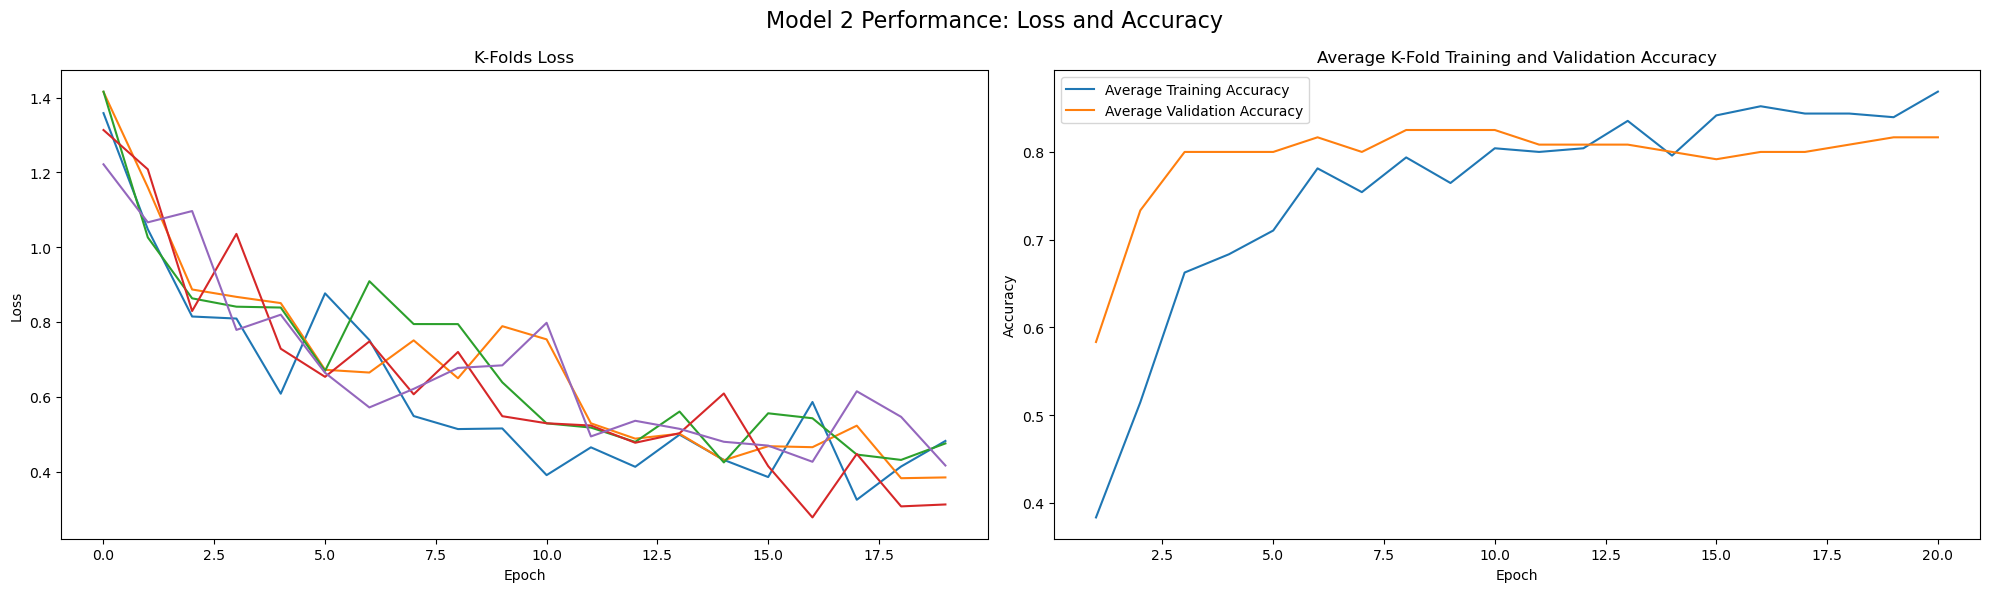

In [ ]:
#graph results
graph_nn_results(2,history)

In [ ]:
#ablation table
results_2_df

,Unnamed: 0,Accuracy,Precision,Recall,F1,Epochs,Batch Size,Learning Rate,Folds,Denses,Drops
0,0,0.775000,0.768676,0.750000,0.758996,20,30,0.020,5,"[16, 8, 0]","[0.5, 0]"
1,1,0.783333,0.803986,0.783333,0.793440,20,30,0.020,5,"[16, 16, 0]","[0.5, 0]"
2,2,0.800000,0.800000,0.766667,0.782979,20,30,0.020,5,"[32, 16, 0]","[0.5, 0]"
3,3,0.783333,0.788406,0.775000,0.781560,20,30,0.020,5,"[32, 32, 0]","[0.5, 0]"
4,4,0.775000,0.786232,0.766667,0.776241,20,30,0.020,5,"[64, 32, 0]","[0.5, 0]"
5,5,0.791667,0.789243,0.750000,0.768610,20,30,0.020,5,"[64, 32, 16]","[0.5, 0.4]"
6,6,0.758333,0.790238,0.741667,0.763990,20,30,0.020,5,"[128, 64, 32]","[0.5, 0.4]"
7,7,0.816667,0.822647,0.766667,0.793264,20,30,0.020,5,"[16, 16, 8]","[0.5, 0.4]"
8,8,0.766667,0.806992,0.766667,0.785808,20,30,0.020,5,"[16, 16, 16]","[0.5, 0.4]"
9,9,0.750000,0.795402,0.708333,0.747419,20,30,0.020,5,"[16, 8, 8]","[0.5, 0.4]"


With the parameters finely tuned, the accuracy reaches approximately 80.15%, placing this performance close to that of our best model. It appears that the deep neural network, which utilizes single feature inputs extracted from the activity, generally outperforms the Recurrent Neural Network (RNN). The latter focuses solely on the activity itself, attempting to automatically discern patterns, but seems to be less effective in this specific context.

## Model Evaluations

#### Running Repeated Samples for Logistic Regression, Adaboost, and XGBoost

We are interested in seeing if there is a significant difference in model performance (accuracy, f1 score, recall, and variance) between these three models.

To do this, we run all three models repeatedly, get the accuracy, f1 score, and recall score for each run, and use an ANOVA test that compares inter-group and intra-group variability to test if there are significant differences in model performance. Neural networks were excluded due to long run times.

### Logistic Regression Sampling

In [74]:
# sampling logistic regression accuracies

# the first runs correspond to the same runs generated above in this notebook (using the same seed)
seed = 42

logistic_accuracies = []
for i in range(10):
    logistic_accuracy = run_logregression(df_depression=df_depression, n_features=25, c=0.1, penalty='l2', solver='saga', metric='accuracy')
    seed += 1
    logistic_accuracies.append(logistic_accuracy.loc['Mean', 'validation_accuracy'])

seed = 42

# sampling logistic regression accuracy variance
logistic_variance_accuracy = list(abs(logistic_accuracy.train_accuracy - logistic_accuracy.validation_accuracy))

# sampling logistic regression f1 scores
logistic_f1s = []
for i in range(10):
    logistic_f1 = run_logregression(df_depression=df_depression, n_features=25, c=0.1, penalty='l2', solver='saga', metric='f1_score')
    seed += 1
    logistic_f1s.append(logistic_f1.loc['Mean', 'validation_f1_score'])

seed = 42

# sampling logistic regression f1 score variance
logistic_variance_f1 = list(abs(logistic_f1.train_f1_score - logistic_f1.validation_f1_score))


# sampling logistic regression recall scores
logistic_recalls = []
for i in range(10):
    logistic_recall = run_logregression(df_depression=df_depression, n_features=25, c=0.1, penalty='l2', solver='saga', metric='recall')
    seed += 1
    logistic_recalls.append(logistic_recall.loc['Mean', 'validation_recall_score'])
seed = 42

# sampling logistic regression recall variance
logistic_variance_recall = list(abs(logistic_recall.train_recall_score - logistic_recall.validation_recall_score))

### Adaboost Sampling

In [75]:
# sampling adaboost accuracies
seed = 42
adaboost_training_accuracies = []
adaboost_validation_accuracies = []
for i in range(10):
    ada_training_accuracy, ada_val_accuracy, ada_acc_grid_result = run_ada(df_depression, seed, metric='accuracy')
    seed += 1
    adaboost_training_accuracies.append(sum(ada_training_accuracy) / len(ada_training_accuracy))
    adaboost_validation_accuracies.append(sum(ada_val_accuracy) / len(ada_val_accuracy))
seed = 42

# sampling adaboost accuracy variance
adaboost_variance_accuracy = [abs(train - val) for train, val in zip(adaboost_training_accuracies, adaboost_validation_accuracies)]

# sampling adaboost f1 scores
seed = 42
adaboost_training_f1s = []
adaboost_validation_f1s = []
for i in range(10):
    ada_training_f1, ada_val_f1, ada_f1_grid_result = run_ada(df_depression, seed, metric='f1')
    seed += 1
    adaboost_training_f1s.append(sum(ada_training_f1) / len(ada_training_f1))
    adaboost_validation_f1s.append(sum(ada_val_f1) / len(ada_val_f1))
seed = 42

# sampling adaboost f1 variance
adaboost_variance_f1 = [abs(train - val) for train, val in zip(adaboost_training_f1s, adaboost_validation_f1s)]

# sampling adaboost recall scores
seed = 42
adaboost_training_recalls = []
adaboost_validation_recalls = []
for i in range(10):
    ada_training_recall, ada_val_recall, ada_recall_grid_result = run_ada(df_depression, seed, metric='recall')
    seed += 1
    adaboost_training_recalls.append(sum(ada_training_recall) / len(ada_training_recall))
    adaboost_validation_recalls.append(sum(ada_val_recall) / len(ada_val_recall))
seed = 42

# sampling adaboost recall variance
adaboost_variance_recall = [abs(train - val) for train, val in zip(adaboost_training_recalls, adaboost_validation_recalls)]

/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.758333 (0.055277) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.808333 (0.077280) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.766667 (0.042492) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.775000 (0.042492) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.750000 (0.052705) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.791667 (0.069722) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.775000 (0.077280) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.758333 (0.103414) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.733333 (0.056519) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.750000 (0.074536) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.747933 (0.071944) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.806955 (0.075744) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.755866 (0.061022) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.759329 (0.060975) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.731546 (0.069037) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.774814 (0.071340) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.768401 (0.074529) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.757051 (0.095080) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.721393 (0.057197) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.730412 (0.087144) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.791726 (0.039061) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.805582 (0.079240) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.781760 (0.036139) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.770503 (0.046845) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.744695 (0.070973) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.779815 (0.066534) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.793932 (0.068914) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.768569 (0.095254) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.740943 (0.039810) with: {'learning_rate': 0.8, 'n_estimators': 100}


/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/vishnupaty/anaconda3/envs/w207/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed 

0.740659 (0.083167) with: {'learning_rate': 0.8, 'n_estimators': 100}


In [76]:
# sampling xgboost accuracies
seed = 42
xgboost_training_accuracies = []
xgboost_validation_accuracies = []
for i in range(10):
    xg_training_accuracy, xg_val_accuracy, xg_acc_grid_result = run_xg(df_depression, seed, metric='accuracy')
    seed += 1
    xgboost_training_accuracies.append(sum(xg_training_accuracy) / len(xg_training_accuracy))
    xgboost_validation_accuracies.append(sum(xg_val_accuracy) / len(xg_val_accuracy))
seed = 42

# sampling xgboost accuracy variance
xgboost_variance_accuracy = [abs(train - val) for train, val in zip(xgboost_training_accuracies, xgboost_validation_accuracies)]

# sampling xgboost f1 scores
seed = 42
xgboost_training_f1s = []
xgboost_validation_f1s = []
for i in range(10):
    xg_training_f1, xg_val_f1, xg_f1_grid_result = run_xg(df_depression, seed, metric='f1')
    seed += 1
    xgboost_training_f1s.append(sum(xg_training_f1) / len(xg_training_f1))
    xgboost_validation_f1s.append(sum(xg_val_f1) / len(xg_val_f1))
seed = 42

# sampling xgboost f1 variance
xgboost_variance_f1 = [abs(train - val) for train, val in zip(xgboost_training_f1s, xgboost_validation_f1s)]

# sampling xgboost f1 scores
seed = 42
xgboost_training_recalls = []
xgboost_validation_recalls = []
for i in range(10):
    xg_training_recall, xg_val_recall, xg_recall_grid_result = run_xg(df_depression, seed, metric='f1')
    seed += 1
    xgboost_training_recalls.append(sum(xg_training_recall) / len(xg_training_recall))
    xgboost_validation_recalls.append(sum(xg_val_recall) / len(xg_val_recall))
seed = 42

# sampling xgboost recall variance
xgboost_variance_recall = [abs(train - val) for train, val in zip(xgboost_training_recalls, xgboost_validation_recalls)]

### ANOVA Test for Accuracy

In [81]:
# Function to calculate mean of list
def mean(n):
    return sum(n) / len(n)

In [77]:
f_statistic, p_value = f_oneway(logistic_accuracies, adaboost_validation_accuracies, xgboost_validation_accuracies)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the model scores.")
else:
    print("There is no statistically significant difference between the model scores.")

F-statistic: 27.983050847457626
P-value: 2.6197000925319476e-07
There is a statistically significant difference between the model scores.


### Post-Hoc Pairwise Comparisons Using Bonferonni Correction for Accuracy

In [78]:
# Set up alpha level
alpha = 0.05
number_of_comparisons = 3  # Comparisons: logistic vs. adaboost, logistic vs. xgboost, adaboost vs. xgboost
bonferroni_corrected_alpha = alpha / number_of_comparisons

# Pairwise comparisons
t_statistic, p_log_ada = ttest_ind(logistic_accuracies, adaboost_validation_accuracies)
t_statistic, p_log_xgb = ttest_ind(logistic_accuracies, xgboost_validation_accuracies)
t_statistic, p_ada_xgb = ttest_ind(adaboost_validation_accuracies, xgboost_validation_accuracies)

# Check significance after Bonferroni correction
if p_log_ada < bonferroni_corrected_alpha:
    print("Logistic and Adaboost models have significantly different accuracies.")
if p_log_xgb < bonferroni_corrected_alpha:
    print("Logistic and XGBoost models have significantly different accuracies.")
if p_ada_xgb < bonferroni_corrected_alpha:
    print("Adaboost and XGBoost models have significantly different accuracies.")


Logistic and Adaboost models have significantly different accuracies.
Adaboost and XGBoost models have significantly different accuracies.


Let's view the accuracies of all models.

In [82]:
# Viewing accuracies
print(f'Logistic Accuracy: {mean(logistic_accuracies)}')
print(f'XGBoost Accuracy: {mean(xgboost_validation_accuracies)}')
print(f'Adaboost Accuracy: {mean(adaboost_validation_accuracies)}')

Logistic Accuracy: 0.8324999999999999
XGBoost Accuracy: 0.8133333333333332
Adaboost Accuracy: 0.7666666666666667


From the results of our omnibus and post-hoc pairwise tests, we can conclude that the Logistic Regression and XGBoost models have a significant improvement in accuracy over Adaboost. Note that the logistic regression accuracy is still the highest even if not statistically significant.

### ANOVA Test for F1 Score

In [83]:
f_statistic, p_value = f_oneway(logistic_f1s, adaboost_validation_f1s, xgboost_validation_f1s)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the model scores.")
else:
    print("There is no statistically significant difference between the model scores.")

F-statistic: 24.33325776818962
P-value: 9.082604283363845e-07
There is a statistically significant difference between the model scores.


### Post-Hoc Pairwise Comparisons Using Bonferonni Correction for F1 Score

In [84]:
# Set up alpha level
alpha = 0.05
number_of_comparisons = 3  # Comparisons: logistic vs. adaboost, logistic vs. xgboost, adaboost vs. xgboost
bonferroni_corrected_alpha = alpha / number_of_comparisons

# Pairwise comparisons
t_statistic, p_log_ada = ttest_ind(logistic_f1s, adaboost_validation_f1s)
t_statistic, p_log_xgb = ttest_ind(logistic_f1s, xgboost_validation_f1s)
t_statistic, p_ada_xgb = ttest_ind(adaboost_validation_f1s, xgboost_validation_f1s)

# Check significance after Bonferroni correction
if p_log_ada < bonferroni_corrected_alpha:
    print("Logistic and Adaboost models have significantly different F1 scores.")
if p_log_xgb < bonferroni_corrected_alpha:
    print("Logistic and XGBoost models have significantly different F1 scores.")
if p_ada_xgb < bonferroni_corrected_alpha:
    print("Adaboost and XGBoost models have significantly different F1 scores.")


Logistic and Adaboost models have significantly different F1 scores.
Adaboost and XGBoost models have significantly different F1 scores.


In [86]:
# Viewing f1 score
print(f'Logistic F1: {mean(logistic_f1s)}')
print(f'XGBoost F1: {mean(xgboost_validation_f1s)}')
print(f'Adaboost F1: {mean(adaboost_validation_f1s)}')

Logistic F1: 0.8227684533929251
XGBoost F1: 0.8053603471589608
Adaboost F1: 0.7553699991647227


We can conclude that the Logistic Regression and XGBoost models have a significant improvement in F1 score over Adaboost. Logistic F1 score is still the highest, even if not statistically significantly different than XGBoost's F1 score.

### ANOVA Test for Recall

In [87]:
f_statistic, p_value = f_oneway(logistic_recalls, adaboost_validation_recalls, xgboost_validation_recalls)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the model scores.")
else:
    print("There is no statistically significant difference between the model scores.")

F-statistic: 19.832381501468777
P-value: 5.021231362969519e-06
There is a statistically significant difference between the model scores.


### Post-Hoc Pairwise Comparisons Using Bonferonni Correction for F1 Score

In [88]:
# Set up alpha level
alpha = 0.05
number_of_comparisons = 3  # Comparisons: logistic vs. adaboost, logistic vs. xgboost, adaboost vs. xgboost
bonferroni_corrected_alpha = alpha / number_of_comparisons

# Pairwise comparisons
t_statistic, p_log_ada = ttest_ind(logistic_recalls, adaboost_validation_recalls)
t_statistic, p_log_xgb = ttest_ind(logistic_recalls, xgboost_validation_recalls)
t_statistic, p_ada_xgb = ttest_ind(adaboost_validation_recalls, xgboost_validation_recalls)

# Check significance after Bonferroni correction
if p_log_ada < bonferroni_corrected_alpha:
    print("Logistic and Adaboost models have significantly different recall scores.")
if p_log_xgb < bonferroni_corrected_alpha:
    print("Logistic and XGBoost models have significantly different recall scores.")
if p_ada_xgb < bonferroni_corrected_alpha:
    print("Adaboost and XGBoost models have significantly different recall scores.")


Logistic and Adaboost models have significantly different recall scores.
Logistic and XGBoost models have significantly different recall scores.
Adaboost and XGBoost models have significantly different recall scores.


In [89]:
# Viewing recall score
print(f'Logistic recall: {mean(logistic_recalls)}')
print(f'XGBoost recall: {mean(xgboost_validation_recalls)}')
print(f'Adaboost recall: {mean(adaboost_validation_recalls)}')

Logistic recall: 0.8359125874125872
XGBoost recall: 0.8053603471589608
Adaboost recall: 0.7718182743182743


We can conclude that the Logistic Regression model has a significant performance improvement in recall score score over the XGBoost and Adaboost models. It is the best model in terms of recall. Since one of our main goals in this project is to minimize false negatives and prevent anyone that shows signs of depression from being misdiagnosed, recall is an important metric.

### ANOVA Test for Accuracy Variance

In [90]:
f_statistic, p_value = f_oneway(logistic_variance_accuracy, adaboost_variance_accuracy, xgboost_variance_accuracy)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the model scores.")
else:
    print("There is no statistically significant difference between the model scores.")

F-statistic: 47.51387582922863
P-value: 6.792858542516468e-09
There is a statistically significant difference between the model scores.


### Post-Hoc Pairwise Comparisons Using Bonferonni Correction for Accuracy Variance

In [94]:
# Set up alpha level
alpha = 0.05
number_of_comparisons = 3  # Comparisons: logistic vs. adaboost, logistic vs. xgboost, adaboost vs. xgboost
bonferroni_corrected_alpha = alpha / number_of_comparisons

# Pairwise comparisons
t_statistic, p_log_ada = ttest_ind(logistic_variance_accuracy, adaboost_variance_accuracy)
t_statistic, p_log_xgb = ttest_ind(logistic_variance_accuracy, xgboost_variance_accuracy)
t_statistic, p_ada_xgb = ttest_ind(adaboost_variance_accuracy, xgboost_variance_accuracy)

# Check significance after Bonferroni correction
if p_log_ada < bonferroni_corrected_alpha:
    print("Logistic and Adaboost models have significantly different variance in accuracy.")
if p_log_xgb < bonferroni_corrected_alpha:
    print("Logistic and XGBoost models have significantly different variance in accuracy.")
if p_ada_xgb < bonferroni_corrected_alpha:
    print("Adaboost and XGBoost models have significantly different variance in accuracy.")

# Viewing mean of accuracy variances for each model
accuracy_variances = pd.Series({
    'Logistic': mean(logistic_variance_accuracy),
    'AdaBoost': mean(adaboost_variance_accuracy),
    'XGBoost': mean(xgboost_variance_accuracy)
})

accuracy_variances


Logistic and Adaboost models have significantly different variance in accuracy.
Logistic and XGBoost models have significantly different variance in accuracy.


Logistic    0.060417
AdaBoost    0.165417
XGBoost     0.186667
dtype: float64

Since the Logistic Regression model has the lowest accuracy variance that is significantly different than that of the other models, we can conclude that the Logistic Regression model is the best model in terms of accuracy variance.

### ANOVA Test for F1 Variance

In [95]:
f_statistic, p_value = f_oneway(logistic_variance_f1, adaboost_variance_f1, xgboost_variance_f1)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the model scores.")
else:
    print("There is no statistically significant difference between the model scores.")

F-statistic: 36.390940509758885
P-value: 7.500866819576911e-08
There is a statistically significant difference between the model scores.


### Post-Hoc Pairwise Comparisons Using Bonferonni Correction for F1 Variance

In [100]:
# Set up alpha level
alpha = 0.05
number_of_comparisons = 3  # Comparisons: logistic vs. adaboost, logistic vs. xgboost, adaboost vs. xgboost
bonferroni_corrected_alpha = alpha / number_of_comparisons

# Pairwise comparisons
t_statistic, p_log_ada = ttest_ind(logistic_variance_f1, adaboost_variance_f1)
t_statistic, p_log_xgb = ttest_ind(logistic_variance_f1, xgboost_variance_f1)
t_statistic, p_ada_xgb = ttest_ind(adaboost_variance_f1, xgboost_variance_f1)

# Check significance after Bonferroni correction
if p_log_ada < bonferroni_corrected_alpha:
    print("Logistic and Adaboost models have significantly different variance in f1.")
if p_log_xgb < bonferroni_corrected_alpha:
    print("Logistic and XGBoost models have significantly different variance in f1.")
if p_ada_xgb < bonferroni_corrected_alpha:
    print("Adaboost and XGBoost models have significantly different variance in f1.")

# Viewing mean of f1 variances 
f1_variances = pd.Series({
    'Logistic': mean(logistic_variance_f1),
    'AdaBoost': mean(adaboost_variance_f1),
    'XGBoost': mean(xgboost_variance_f1)
})

f1_variances



Logistic and Adaboost models have significantly different variance in f1.
Logistic and XGBoost models have significantly different variance in f1.


Logistic    0.070543
AdaBoost    0.175967
XGBoost     0.194640
dtype: float64

Since the Logistic Regression model has the lowest f1 variance that is significantly different than that of the other models, we can conclude that the Logistic Regression model is the best model in terms of f1 variance as well.

### ANOVA Test for Recall Variance

In [97]:
f_statistic, p_value = f_oneway(logistic_variance_recall, adaboost_variance_recall, xgboost_variance_recall)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the model scores.")
else:
    print("There is no statistically significant difference between the model scores.")

F-statistic: 35.56900431285896
P-value: 9.153191161380656e-08
There is a statistically significant difference between the model scores.


### Post-Hoc Pairwise Comparisons Using Bonferonni Correction for Recall Variance

In [99]:
# Set up alpha level
alpha = 0.05
number_of_comparisons = 3  # Comparisons: logistic vs. adaboost, logistic vs. xgboost, adaboost vs. xgboost
bonferroni_corrected_alpha = alpha / number_of_comparisons

# Pairwise comparisons
t_statistic, p_log_ada = ttest_ind(logistic_variance_recall, adaboost_variance_recall)
t_statistic, p_log_xgb = ttest_ind(logistic_variance_recall, xgboost_variance_recall)
t_statistic, p_ada_xgb = ttest_ind(adaboost_variance_recall, xgboost_variance_recall)

# Check significance after Bonferroni correction
if p_log_ada < bonferroni_corrected_alpha:
    print("Logistic and Adaboost models have significantly different variance in recall.")
if p_log_xgb < bonferroni_corrected_alpha:
    print("Logistic and XGBoost models have significantly different variance in recall.")
if p_ada_xgb < bonferroni_corrected_alpha:
    print("Adaboost and XGBoost models have significantly different variance in recall.")

# Viewing mean of recall variances for each model

recall_variances = pd.Series({
    'Logistic': mean(logistic_variance_recall),
    'AdaBoost': mean(adaboost_variance_recall),
    'XGBoost': mean(xgboost_variance_recall)
})

recall_variances



Logistic and Adaboost models have significantly different variance in recall.
Logistic and XGBoost models have significantly different variance in recall.
Adaboost and XGBoost models have significantly different variance in recall.


Logistic    0.062410
AdaBoost    0.159741
XGBoost     0.194640
dtype: float64

Again, since the Logistic Regression model has the lowest recall variance that is significantly different than that of the other models, we can conclude that the Logistic Regression model is the best model in terms of recall variance as well.

To summarize, logistic regression had the highest accuracy and f1 score, and signficantly higher recall and significantly lower variance than the other models. Particularly because recall is one of our most valued metrics, we believe Logistic Regression is overall our best performing model. It does the best job at classifying depression status, balancing false positives and negatives, minimizing false negatives, and overfits less than the other models. 

Now let's look at the confusion matrix for logistic regression to see how it performs at classifying each class correctly. Ideally we'd like to see equal ability to classify each of the three classes. We will use accuracy as the metric.

In [104]:
def run_logregression_confusion(df_depression, n_features, c, penalty, solver):

    # Initialize aggregate confusion matrix
    aggregate_cm = np.zeros((3, 3))

    # Calculate column index for last feature
    last_feature_index = n_features + 1

    # Split the data into X and y
    X = np.array(df_depression.iloc[:, 1:last_feature_index])
    X_std = StandardScaler().fit_transform(X)
    y = np.array(df_depression.iloc[:, 0])

    # Create the logistic regression model with the specified hyperparameters
    log_model = LogisticRegression(C=c, penalty=penalty, solver=solver, max_iter=2000)


    # Define the evaluation procedure with k-fold cross-validation
    k_folds = 5
    cv = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

    # Lists to store training and validation scores for each fold
    train_accuracies = []
    validation_accuracies = []

    # Perform cross-validation and get training and validation scores for each fold
    for train_index, validation_index in cv.split(X_std, y):
        X_train, X_val = X_std[train_index], X_std[validation_index]
        y_train, y_val = y[train_index], y[validation_index]

        # Train the model on the training set within each fold
        log_model.fit(X_train, y_train)

        predicted_labels = log_model.predict(X_val)
        cm = confusion_matrix(y_val, predicted_labels, labels=[0, 1, 2])  # Assuming labels are 0, 1, and 2
        aggregate_cm += cm

    return aggregate_cm
    


In [109]:
def plot_confusion_matrix(matrix):
    # Labels
    classes = ["No depression", "Mild depression", "Moderate depression"]

    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Logistic Regression Confusion Matrix (aggregated across k-folds)")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Displaying the actual numbers in the matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, format(matrix[i, j], '.1f'),
                    horizontalalignment="center",
                    color="white" if matrix[i, j] > matrix.max() / 2. else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

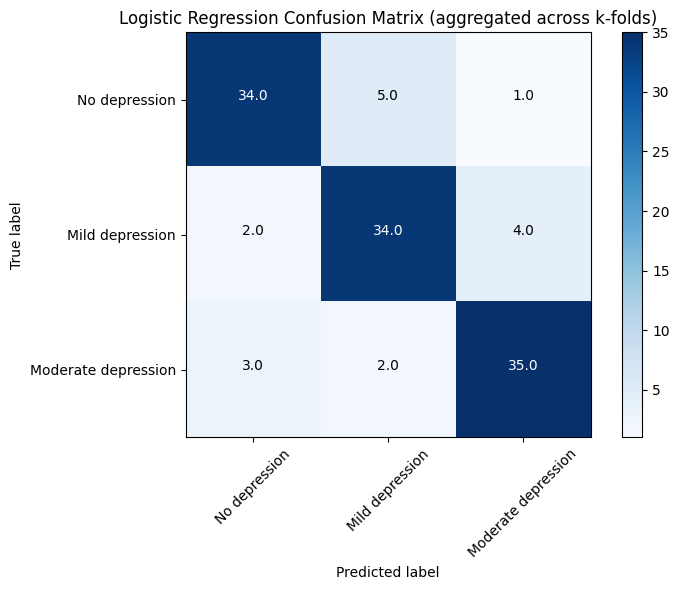

In [110]:
# Visualize confusion matrix
matrix = run_logregression_confusion(df_depression=df_depression, n_features=25, c=0.1, penalty='l2', solver='saga')
plot_confusion_matrix(matrix)

Logistic regression performs almost equally well at correctly classifying each class. Overall, we would recommend logistic regression as a simpler and fast approach to classifying depression status using motion actigraph data

### Visualizing Model Performance

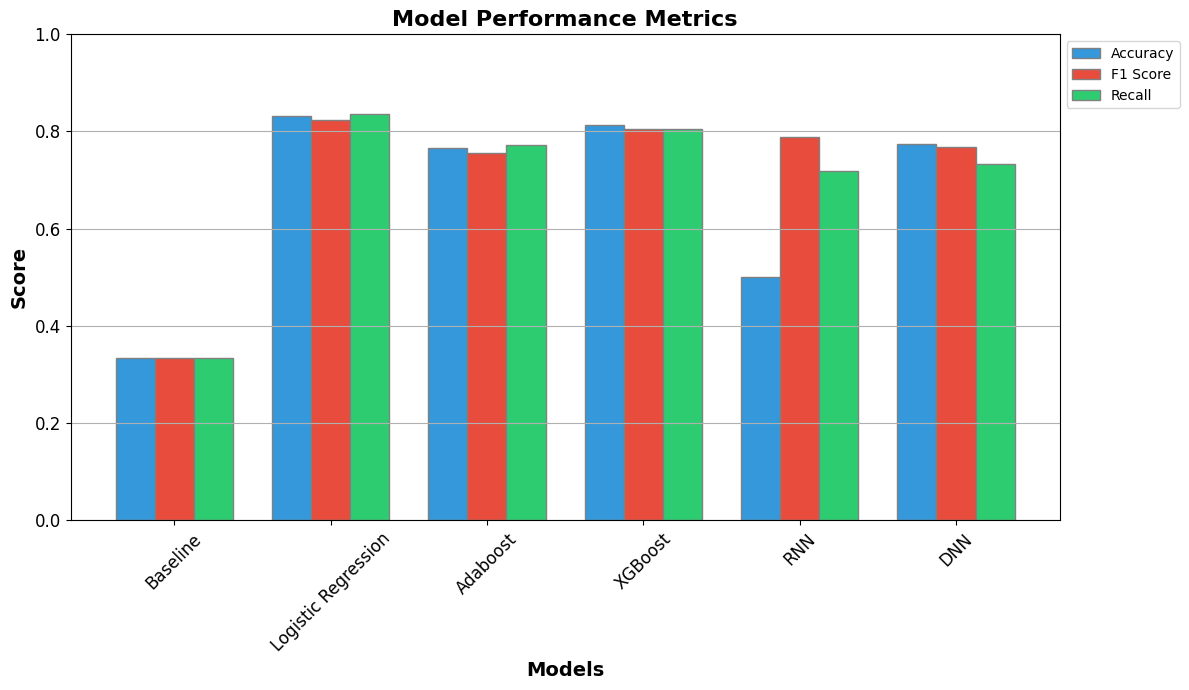

In [111]:
# Model metrics
models = ["Baseline", "Logistic Regression", "Adaboost", "XGBoost", "RNN", "DNN"]
accuracy = [0.3333, mean(logistic_accuracies), mean(adaboost_validation_accuracies), mean(xgboost_validation_accuracies), 0.5, 0.775]
f1_score = [0.3333, mean(logistic_f1s), mean(adaboost_validation_f1s), mean(xgboost_validation_f1s), 0.788571384578472, 0.7686051477971905]
recall = [0.3333, mean(logistic_recalls), mean(adaboost_validation_recalls), mean(xgboost_validation_recalls), 0.71875, 0.7333333253860473]

barWidth = 0.25
r1 = np.arange(len(accuracy))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Plotting
plt.figure(figsize=(12,7))
plt.bar(r1, accuracy, color='#3498db', width=barWidth, edgecolor='grey', label='Accuracy')
plt.bar(r2, f1_score, color='#e74c3c', width=barWidth, edgecolor='grey', label='F1 Score')
plt.bar(r3, recall, color='#2ecc71', width=barWidth, edgecolor='grey', label='Recall')

plt.title('Model Performance Metrics', fontweight='bold', fontsize=16)
plt.xlabel('Models', fontweight='bold', fontsize=14)
plt.ylabel('Score', fontweight='bold', fontsize=14)
plt.xticks([r + barWidth for r in range(len(accuracy))], models, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


The model seems to classify all groups equally across the k-folds (I averaged over the k-folds).

## Conclusions

After using ablation analysis and grid search to optimize hyperparameters for Logistic Regression, Adaboost, and XGBoost, we discovered that Logistic Regression significantly outperforms the other two models in terms of recall and variance (while significantly outperforming Adaboost in accuracy and f1 score and having the highest values for these metrics). In other words, it does a better job at classifying depression status, minimizing false negatives, and overfits less than the other models, including the two neural networks tested. It also performs almost equally well at classifying each group. We would recommend Logistic Regression as a simpler approach to classifying depression status. Changes in dataset sizes and the inclusion of detailed demographic features may change this recommendation to favor more complex approaches, such as neural networks.   

Next steps could include expanding the dataset size and demographic representation to improve the generalizability, working closely with mental health professionals to implement real-world solutions such as applications or tools that can be easily used for monitoring of depression, and also considering the ethical implications in the model application.

Despite our concerns regarding data generalizability and potential biases, the evidence sufficiently justifies further research into leveraging the power of machine learning on activity data. This could ultimately lead to enhanced and more readily accessible mental health support.
